### **Aim of the Project**
**The aim of the project is to build a Machine Learning
Model to predict whether an owner will initiate an auto
insurance claim in the next year.**

The auto insurance industry is witnessing a paradigm shift. Since auto insurance company consists of homogenous good thereby making it difficult to differentiate product A from product B, also companies are fighting a price war (for insurance price). On top of that, the
distribution channel is shifting more from traditional insurance brokers to online purchases,which means that the ability for companies to interact through human touchpoints is limited,
and customers should be quoted at a reasonable price. A good price quote is one that makes the customer purchase the policy and helps the company to increase the profits. Also, the insurance premium is calculated based on more than 50+ parameters, which means that traditional business analytics-based algorithms are now limited in their ability to differentiate among customers based on subtle parameters.

In [81]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,Normalizer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,balanced_accuracy_score,accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import xgboost
from scipy import stats
from sklearn.svm import SVC


In [83]:
data=pd.read_csv('/content/drive/My Drive/auto_insurance_data.csv')
data=data.drop(['id'],axis=1)
data.shape

(595212, 58)

In [84]:
data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.610991,0.439184,0.551102,8.295933,0.829948,-0.504899,0.725192,-0.157732,6.555340,0.910027,0.832080,1.328890,0.992136,62.215674,2.346072,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.287643,0.404264,0.793506,2.508270,0.375679,0.788654,2.153463,0.844417,5.501445,0.347106,0.373796,0.978747,0.091619,33.012455,0.832548,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.525000,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.720677,7.000000,1.000000,-1.000000,0.000000,0.000000,7.000000,1.000000,1.000000,2.000000,1.000000,65.000000,3.000000,0.374166,0.765811,0.3687

From the initial glance of the dataset, it can be observed that the minimum values in some features are -1, indicating the presence of missing values and some features have negative mean,indicating large number of missing values.

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17_

In [0]:
# Splitting the columns on the basis of feature type
cat_var=[]
bin_var=[]
intr_var=[]
ord_var=[]
target=[]
for i in data.columns:
  if 'cat' in i:
    cat_var.append(i)
  elif 'bin' in i:
    bin_var.append(i)
  elif data[i].dtype==float:
    intr_var.append(i)
  elif (data[i].dtype==int and i!='target'):
    ord_var.append(i)
  elif i == 'target':
    target.append(i)
  else:
    othr_var.append(i)

### **INTERVAL DATA**

In [0]:
# Separating the data with target =1
target_1=data[data['target']==1]

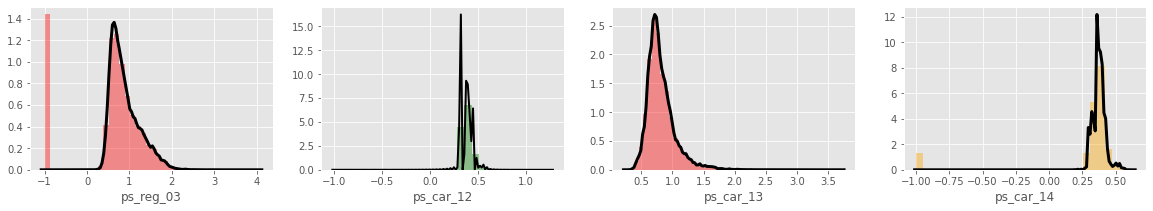

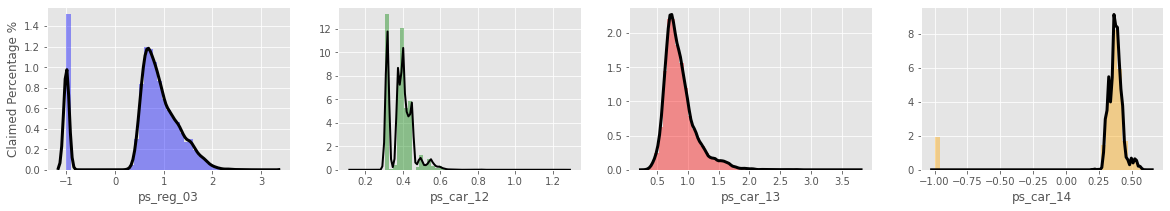

In [88]:
plt.subplots(1,4,figsize=(20,3))
plt.subplot(1,4,1)
sns.distplot(data[intr_var[2]],kde=True,bins=40,color='r',kde_kws={"color": "k", "lw": 3})
plt.subplot(1,4,2)
sns.distplot(data[intr_var[3]],kde=True,bins=30,color='g',kde_kws={"color": "k", "lw": 2})
plt.subplot(1,4,3)
sns.distplot(data[intr_var[4]],kde=True,bins=50,color='r',kde_kws={"color": "k", "lw": 3})
plt.subplot(1,4,4)
sns.distplot(data[intr_var[5]],kde=True,bins=30,color='orange',kde_kws={"color": "k", "lw": 3})
plt.show()
plt.subplots(1,4,figsize=(20,3))
plt.subplot(1,4,1)
sns.distplot(target_1[intr_var[2]],kde=True,bins=45,color='b',kde_kws={"color": "k", "lw": 3})
plt.ylabel('Claimed Percentage %')
plt.subplot(1,4,2)
sns.distplot(target_1[intr_var[3]],kde=True,bins=55,color='g',kde_kws={"color": "k", "lw": 2})
plt.subplot(1,4,3)
sns.distplot(target_1[intr_var[4]],kde=True,bins=50,color='r',kde_kws={"color": "k", "lw": 3})
plt.subplot(1,4,4)
sns.distplot(target_1[intr_var[5]],kde=True,bins=40,color='orange',kde_kws={"color": "k", "lw": 3})
plt.show()

In [0]:
def intr_plot(i,width):
   plt.title(intr_var[i])
   y=round(data[intr_var[i]].groupby(data[intr_var[i]]).count()*100/len(data['target']),2)
   plt.bar(y.index,y.values,width=width,color='r',label='Original Distribution')
   plt.xticks(np.linspace(data[intr_var[i]].min(),data[intr_var[i]].max(),5))
   y=round(target_1[intr_var[i]].groupby(target_1[intr_var[i]]).count()*100/len(target_1['target']),2)
   plt.bar(y.index,y.values,width=width,color='b',label='Claimed Distribution')
   plt.xticks(np.linspace(target_1[intr_var[i]].min(),target_1[intr_var[i]].max(),5))


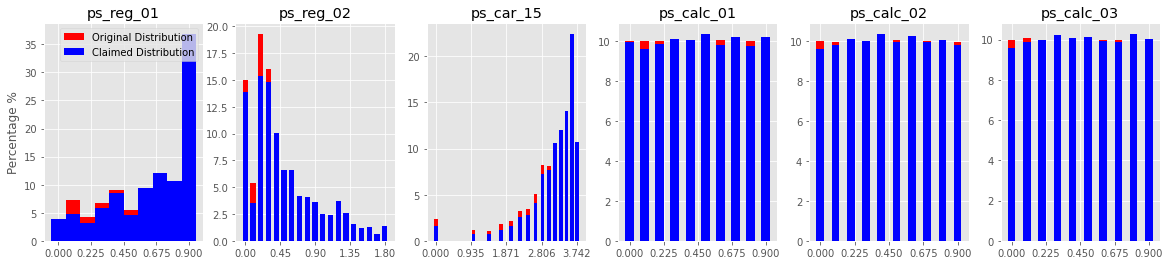

In [90]:
plt.subplots(1,6,figsize=(20,4))
plt.subplot(1,6,1)
intr_plot(0,0.1)
plt.ylabel('Percentage %')
plt.legend()
plt.subplot(1,6,2)
intr_plot(1,0.07)
plt.subplot(1,6,3)
intr_plot(6,0.1)
plt.subplot(1,6,4)
intr_plot(7,0.06)
plt.subplot(1,6,5)
intr_plot(8,0.05)
plt.subplot(1,6,6)
intr_plot(9,0.05)

- The **reg** and **car** features are showing both and positively and negatively skewed distribution. The **ps_reg_01** and **ps_car_15** features are showing an unusual spike at higher values.
- The **calc** features i.e. calc_01,2 & 3 are showing uniform distribution.
- The Feature **ps_reg_02** shows positive distribution with maximum frequency occuring at 0.2 whereas **ps_car_15** shows negative distribution with maximum frequency occuring at 3.6.  

### **CATEGORICAL DATA**

#### **Distribution of features**


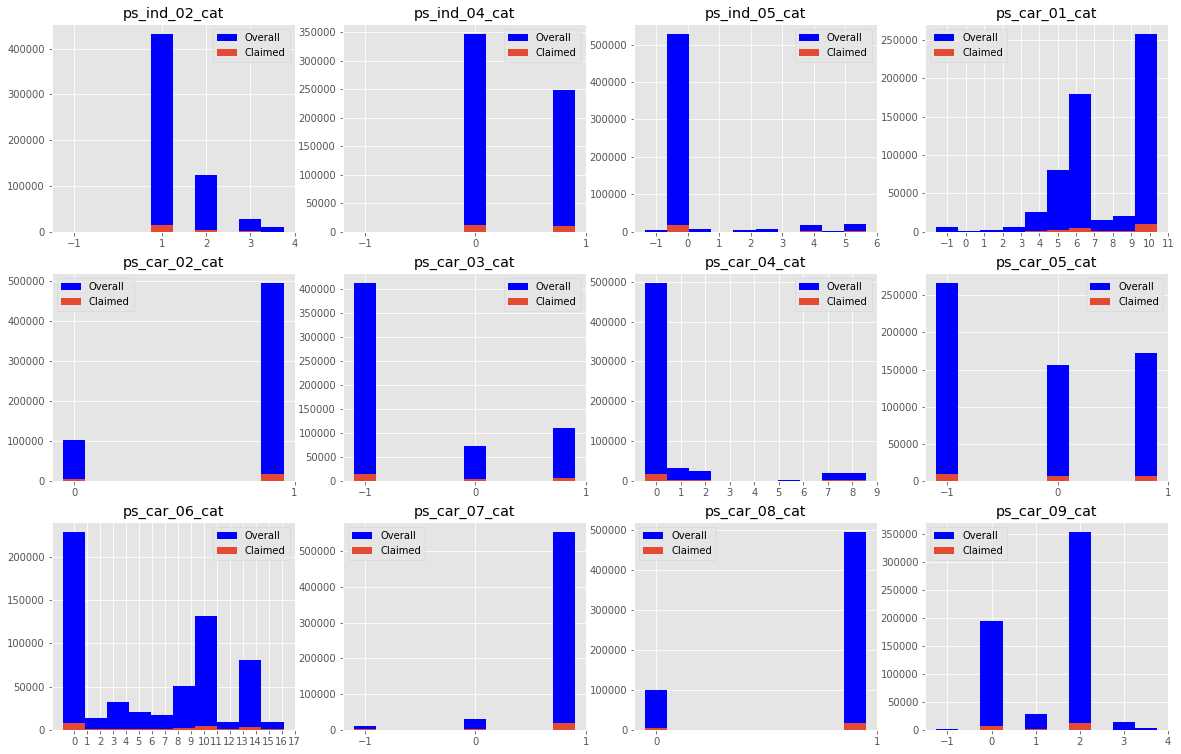

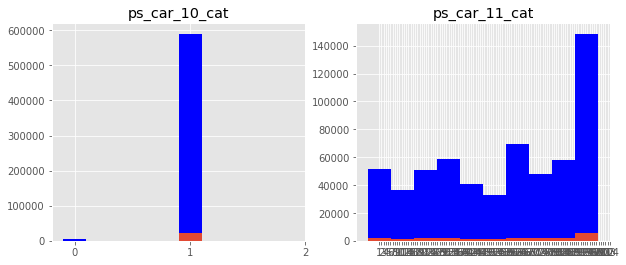

In [91]:
plt.style.use('ggplot')
plt.subplots(3,4,figsize=(20,10))
plt.subplots_adjust(bottom=-0.1)
for i in range(len(cat_var[:-2])):
  plt.subplot(3,4,i+1)
  plt.title(cat_var[i])
  data[cat_var[i]].hist(align='left',color='b',label='Overall')
  target_1[cat_var[i]].hist(align='left',label='Claimed')
  plt.xticks(data[cat_var[i]].unique())
  plt.legend()
plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
data[cat_var[-2]].hist(align='left',color='b')
target_1[cat_var[-2]].hist(align='left')
plt.xticks(data[cat_var[-2]].unique())
plt.title(cat_var[-2])
plt.subplot(1,2,2)
data[cat_var[-1]].hist(align='left',color='b')
target_1[cat_var[-1]].hist(align='left')
plt.xticks(data[cat_var[-1]].unique())
plt.title(cat_var[-1])
plt.show()

- It can be observed that the categorical features have varying labels.
- Some of the features such as **ps_ind_05_cat,ps_car_02_cat,ps_car_10_cat,ps_car_07_cat,ps_car_08_cat** are very unbalanced.
- The feature **ps_car_11_cat** have 104 unique labels and maximum frequency occuring at 104.
- The feature **ps_car_11_cat** looks similar to interval features such as **ps_reg_01** and **ps_car_15** in distribution.
- In feature **ps_car_03_cat**, the percentage of -1 i.e. missing values is very high and can't be treated as a label.

**Exploring the contribution of each feature towards insurance claim.**

In [0]:
new_cat_var=target_1[cat_var].nunique().sort_values().index

In [0]:
# Plotting function
def cat_bar_plot(i,width):
  plt.title(new_cat_var[i])
  y=target_1[new_cat_var[i]].groupby(target_1[new_cat_var[i]]).count()*100/len(target_1['target'])
  plt.bar(y.index,y.values,width=width,color=['black', 'red', 'green', 'blue', 'cyan'])
  plt.xticks(target_1[new_cat_var[i]].unique())
  plt.ylabel("Percentage claimed %")
  #plt.xlabel("Classes")

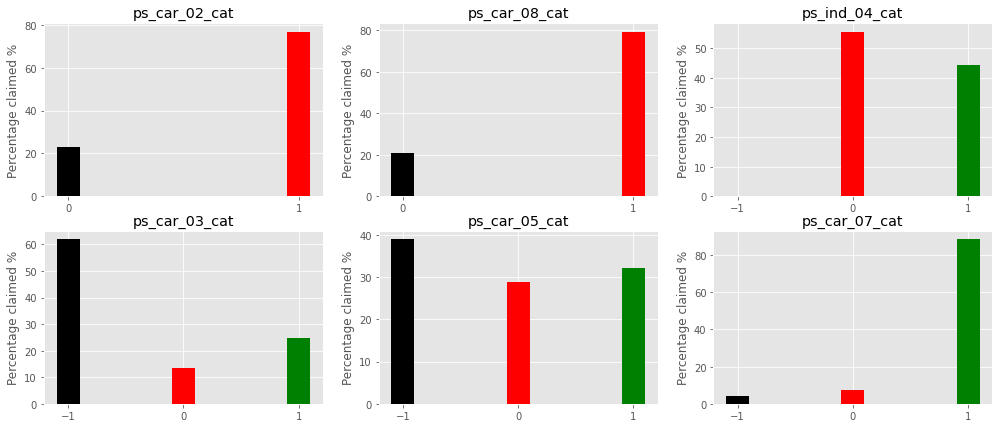

In [94]:
plt.subplots(2,3,figsize=(17,7),sharex=True,sharey=True)
plt.subplot(2,3,1)
cat_bar_plot(0,0.1)
plt.subplot(2,3,2)
cat_bar_plot(1,0.1)
plt.subplot(2,3,3)
cat_bar_plot(2,0.2)
plt.subplot(2,3,4)
cat_bar_plot(3,0.2)
plt.subplot(2,3,5)
cat_bar_plot(4,0.2)
plt.subplot(2,3,6)
cat_bar_plot(5,0.2)
plt.show()

- The correlation of class 1 of the feature **ps_car_07_cat** with claimed percentage is very significant followed by **ps_car_02_cat & ps_car_08_cat**.

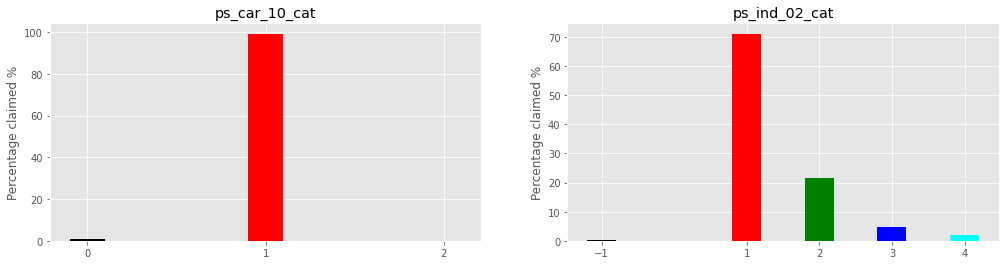

In [95]:
plt.subplots(1,2,figsize=(17,4),sharex=True,sharey=True)
plt.subplot(1,2,1)
cat_bar_plot(6,0.2)
plt.subplot(1,2,2)
cat_bar_plot(7,0.4)
plt.show()

- It appears that the correlation of class1 of the**ps_car_10_cat** is approximately 99% but from the distribution it can be seen that this feature is highly imbalanced, with frequency of class 0 as almost negligible. So this feature will not help much in prediction.

- Interestingly, the correlation of **ps_ind_02_cat** with claimed percentage and the distribution of this feature appears similar.

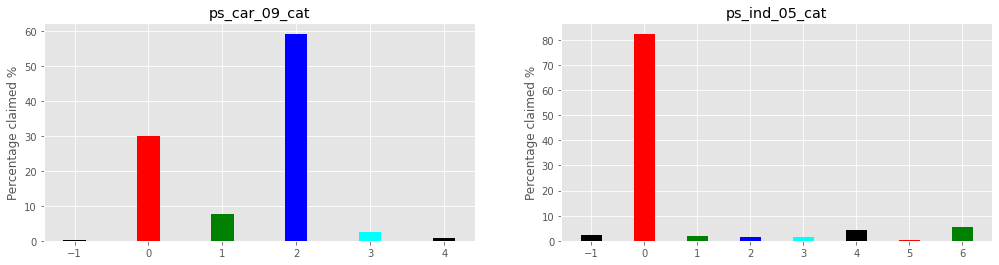

In [96]:
plt.subplots(1,2,figsize=(17,4),sharex=True,sharey=True)
plt.subplot(1,2,1)
cat_bar_plot(8,0.3)
plt.subplot(1,2,2)
cat_bar_plot(9,0.4)
plt.show()

- In **ps_ind_05_cat** the class 0 is highly dominating that is why this class appears to be highly correlated with claimed percentage.
- Class 0 and 2 in **ps_car_09_cat** shows significant correlation with claimed percentage.

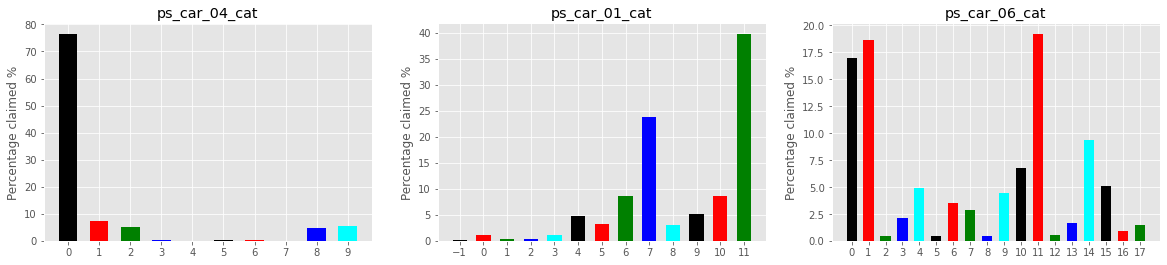

In [97]:
plt.subplots(1,3,figsize=(20,4),sharex=True,sharey=True)
plt.subplot(1,3,1)
cat_bar_plot(10,0.6)
plt.subplot(1,3,2)
cat_bar_plot(11,0.6)
plt.subplot(1,3,3)
cat_bar_plot(12,0.6)
plt.show()

- All three features have correlation similar to their distribution.

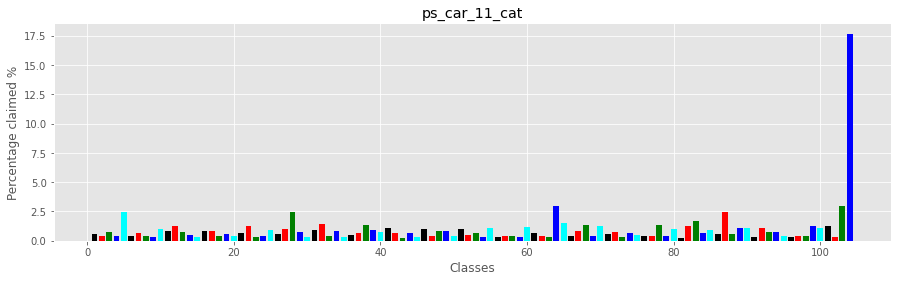

Largest contribution by label= 104  Percentage= 17.65 %


In [98]:
plt.figure(figsize=(15,4))
plt.title(new_cat_var[13])
y=target_1[new_cat_var[13]].groupby(target_1[new_cat_var[13]]).count()*100/len(target_1['target'])
plt.bar(y.index,y.values,color=['black', 'red', 'green', 'blue', 'cyan'])
plt.ylabel("Percentage claimed %")
plt.xlabel("Classes")
plt.show()
x=round((target_1[new_cat_var[13]].groupby(target_1[new_cat_var[13]]).count()*100/len(target_1['target'])).sort_values(ascending=False),2)
print('Largest contribution by label=',x.index[0],' Percentage=',x.values[0],'%')

There are many labels in this feature with almost similar claim percentage except for label 104 that has a percentage of 17.5%.

### **BINARY DATA**

There are total 17 binary features in the dataset. Let's check the distribution of the features

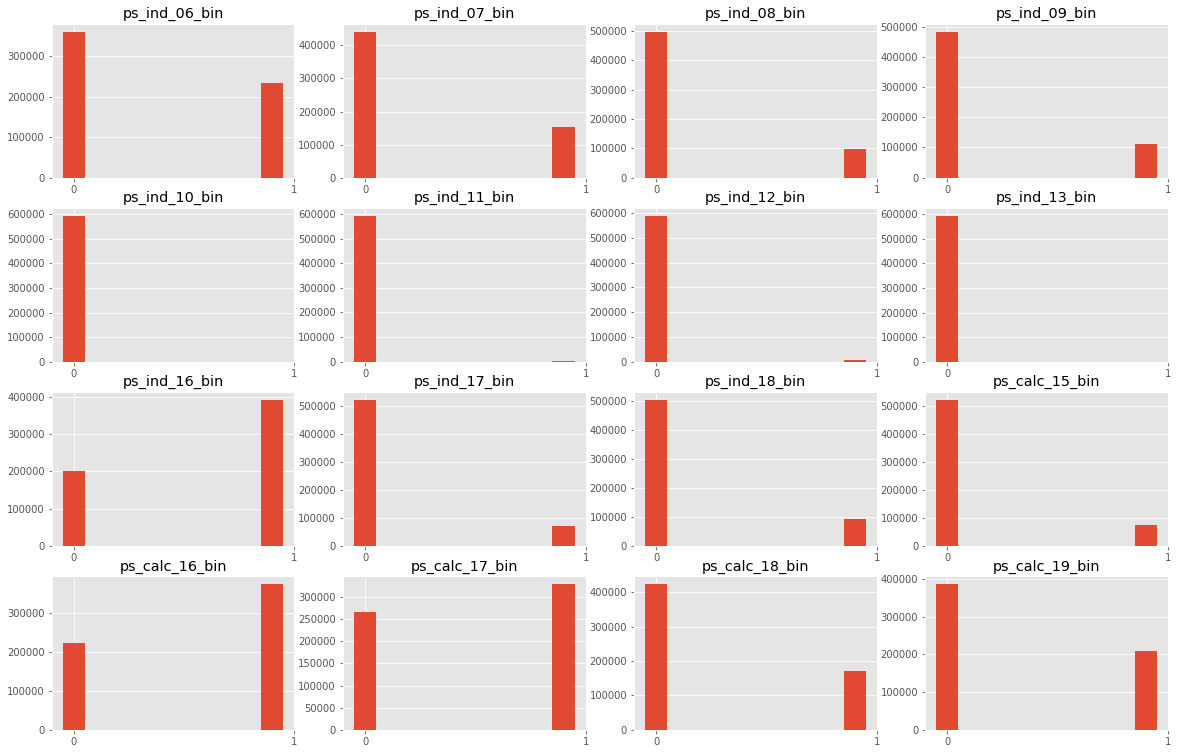

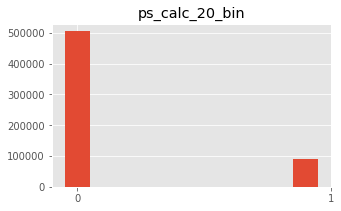

In [99]:
plt.subplots(4,4,figsize=(20,10))
plt.subplots_adjust(bottom=-0.1)
plt.style.use('ggplot')
for i in range(len(bin_var[:-1])):
  plt.subplot(4,4,i+1)
  plt.title(bin_var[i])
  data[bin_var[i]].hist(align='left')
  plt.xticks(data[bin_var[i]].unique())
plt.subplots(1,1,figsize=(5,3))
plt.subplot(1,1,1)
data[bin_var[-1]].hist(align='left')
plt.xticks(data[bin_var[-1]].unique())
plt.title(bin_var[-1])
plt.show()

- The above plots show the distribution of binary features.
- In features **ps_ind_10,11,12 & 13** the frequency of class 1 is almost negligible to none. Therefore they will not be able to contribute towards prediction.
- There appears to be a significant difference in frequency in some of the features.

**Analysing the contribution of individual binary feature towards insurance claim.**

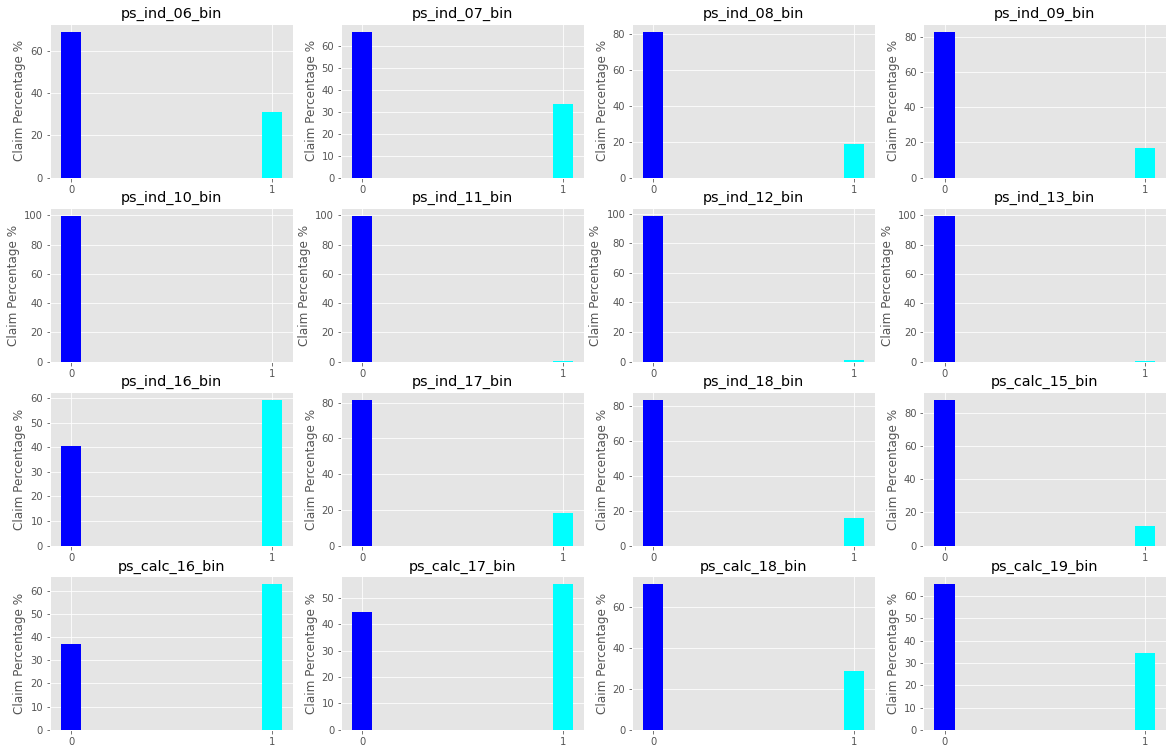

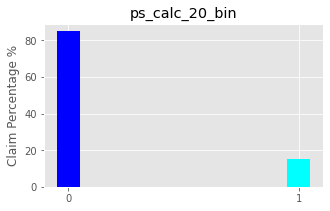

In [100]:
plt.subplots(4,4,figsize=(20,10))
plt.subplots_adjust(bottom=-0.1)
for i in range(len(bin_var[:-1])):
  plt.subplot(4,4,i+1)
  plt.title(bin_var[i])
  y=round(target_1[bin_var[i]].groupby(target_1[bin_var[i]]).count()*100/len(target_1['target']),2)
  plt.bar(y.index,y.values,width=0.1,color=['blue', 'cyan','black', 'red', 'green'])
  plt.xticks(data[bin_var[i]].unique())
  plt.ylabel('Claim Percentage %')
plt.figure(figsize=(5,3))
x=round(target_1[bin_var[-1]].groupby(target_1[bin_var[-1]]).count()*100/len(target_1['target']),2)
plt.bar(x.index,x.values,width=0.1,color=['blue', 'cyan'])
plt.xticks(data[bin_var[i]].unique())
plt.ylabel('Claim Percentage %')
plt.title(bin_var[-1])
plt.show()

- In most of the features, the class 0 is commanding maximum claim percentage except ps_ind_16_bin,ps_calc_16_bin and ps_calc_17_bin.
- Claim percentages of Class 0 of ps_ind_10,11,12 and 13 features are almost 99% but it's not a matter of surprise as the percentages of class one all these features are almost negligible.


### **ORDINAL DATA**

**Visualizing the feature distribution**

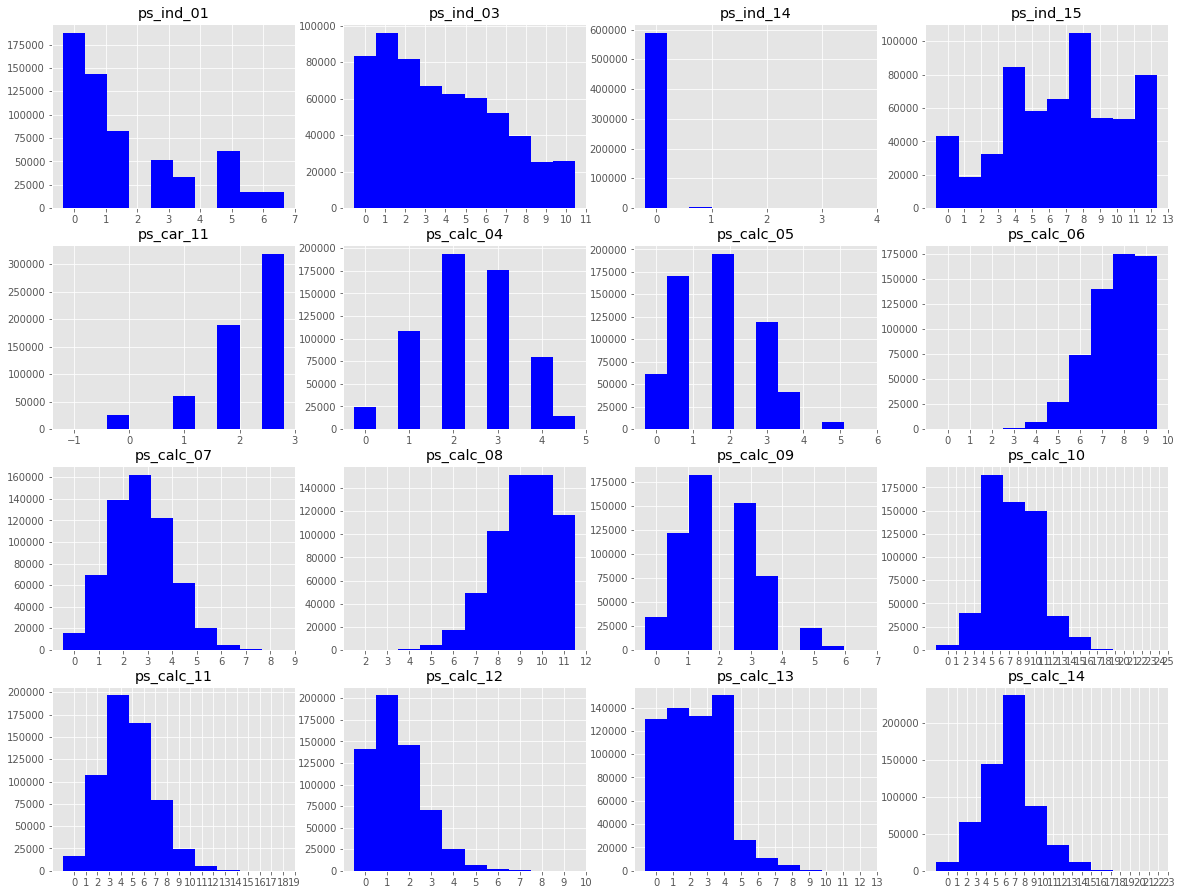

In [101]:
plt.subplots(4,4,figsize=(20,12))
plt.subplots_adjust(bottom=-0.1)
plt.style.use('ggplot')
for i in range(len(ord_var)):
  plt.subplot(4,4,i+1)
  plt.title(ord_var[i])
  data[ord_var[i]].hist(align='left',color='blue')
  plt.xticks(data[ord_var[i]].unique())
plt.show()

- It can be observed that in feature **ps_ind_14** is very imbalanced the percentage of one is almost negligible, hence this feature will not have any impact on the prediction. 
- The features such as **ps_car_11,ps_calc_04,5,8,12** showing skewed distribution.    
- The features **ps_calc_07,10,11 and 14** showing approximately normal distribution.

**Checking the impact of individual ordinal feature towards target feature**

In [0]:
# Defining function to plot bar graph
def ord_plot(i,width):
   plt.title(ord_var[i])
   y=round(target_1[ord_var[i]].groupby(target_1[ord_var[i]]).count()*100/len(target_1['target']),2)
   plt.bar(y.index,y.values,width=width,color=['blue', 'cyan','black', 'red', 'green'])
   plt.xticks(data[ord_var[i]].unique())
   plt.ylabel('Claim Percentage %')

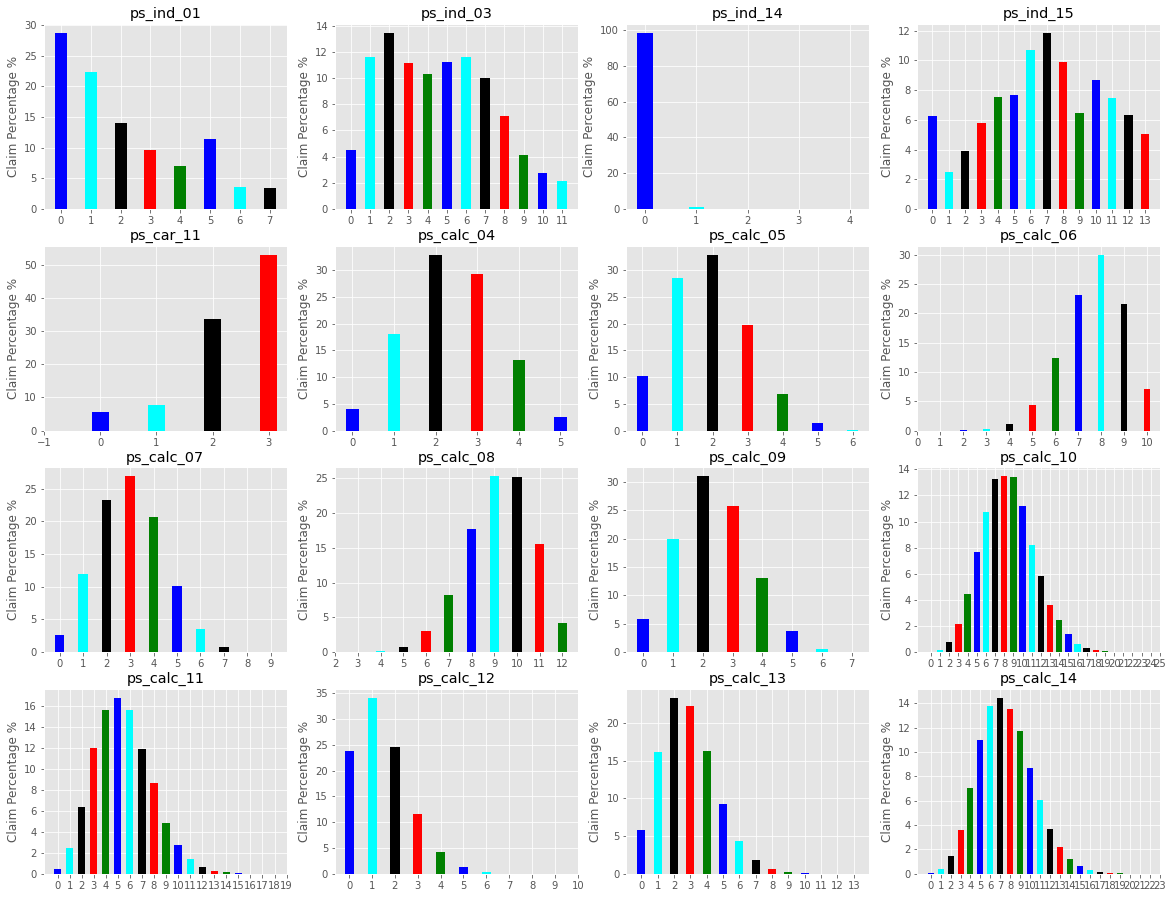

In [103]:
plt.subplots(4,4,figsize=(20,10))
plt.subplots_adjust(bottom=-0.3)
plt.subplot(4,4,1)
ord_plot(0,0.4)
plt.subplot(4,4,2)
ord_plot(1,0.5)
plt.subplot(4,4,3)
ord_plot(2,0.3)
plt.subplot(4,4,4)
ord_plot(3,0.5)
plt.subplot(4,4,5)
ord_plot(4,0.3)
plt.subplot(4,4,6)
ord_plot(5,0.3)
plt.subplot(4,4,7)
ord_plot(6,0.3)
plt.subplot(4,4,8)
ord_plot(7,0.3)
plt.subplot(4,4,9)
ord_plot(8,0.4)
plt.subplot(4,4,10)
ord_plot(9,0.4)
plt.subplot(4,4,11)
ord_plot(10,0.4)
plt.subplot(4,4,12)
ord_plot(11,0.7)
plt.subplot(4,4,13)
ord_plot(12,0.6)
plt.subplot(4,4,14)
ord_plot(13,0.4)
plt.subplot(4,4,15)
ord_plot(14,0.5)
plt.subplot(4,4,16)
ord_plot(15,0.6)

On visualizing the impact of individual feature towards claim percentage, it can be observed that:- <br/>
 - **pd_ind_14** doesn't have much impact as proportion of one and zero is highly imbalanced.
 - **ps_ind_03** and **ps_ind_05** , many feature elements have similar impact with 3 and 7 having maximum share repectively.
 - **ps_ind_01,ps_car_11** and **ps_calc_12** are having positively and negatively skewed distribution with 0,3 and 1 are having maximum percentage respectively.
 - **ps_calc_04,5,6,7,8,9,10,11,13 and 14**, features showing normal distribution with varied standard deviation.

### **MISSING VALUES**

In [0]:
# CREATING A LIST OF FEATURES
features=list(data.columns)

**Computing the percentage of missing values in the original dataset.**

In [105]:
# CHECK FOR MISSING VALUES IN THE DATA. MISSING VALUES ARE REPRESENTED AS -1
print('FEATURE','                        COUNT','          MISSING VALUES (%)')
print('')
missing_val_feat=[]
per1=[]
for i in features:
  count=0
  mylist=list(data[i])
  count=mylist.count(-1)
  per=round(count*100/data[i].count(),2)
  if count!=0:
    missing_val_feat.append(i)
    per1.append(per)
    print(f'{i:{20}}{count:{15}}{per:{25}}')
 

FEATURE                         COUNT           MISSING VALUES (%)

ps_ind_02_cat                   216                     0.04
ps_ind_04_cat                    83                     0.01
ps_ind_05_cat                  5809                     0.98
ps_reg_03                    107772                    18.11
ps_car_01_cat                   107                     0.02
ps_car_03_cat                411231                    69.09
ps_car_05_cat                266551                    44.78
ps_car_07_cat                 11489                     1.93
ps_car_09_cat                   569                      0.1
ps_car_11                         5                      0.0
ps_car_12                         1                      0.0
ps_car_14                     42620                     7.16


- It can be observed that the percentages of missing values are high in **ps_reg_03,ps_car_03_cat and ps_car_05_cat**. Imputing the missing values in these features might not give reliable result so its better to remove these features.
- The features having missing values 1% or less can be removed row wise without significant data loss.But first let's check how much these missing values sharing claim percentage.



**Calculating the percentage of missing values when the target feature containing only ones i.e for insurance claimed.** 

In [106]:
#print('FEATURE','                        COUNT','          MISSING VALUES (%)')
print('')
missing_val_feat1=[]
per2=[]
for i in features:
  count=0
  mylist=list(target_1[i])
  count=mylist.count(-1)
  per=round(count*100/target_1[i].count(),2)
  if count!=0:
    missing_val_feat1.append(i)
    per2.append(per)
    #print(f'{i:{20}}{count:{15}}{per:{25}}')
pd.DataFrame([per1,per2],index=['Overall %','Within Claimed %'],columns=missing_val_feat).T

,Overall %,Within Claimed %
ps_ind_02_cat,0.04,0.18
ps_ind_04_cat,0.01,0.15
ps_ind_05_cat,0.98,2.23
ps_reg_03,18.11,14.11
ps_car_01_cat,0.02,0.16
ps_car_03_cat,69.09,62.00
ps_car_05_cat,44.78,38.96
ps_car_07_cat,1.93,4.14
ps_car_09_cat,0.10,0.24
ps_car_11,0.00,7.94


- On comparing the missing values percentage in overall feature and within claimed, it can be seen that percentage has increased. 
- Removing these missing values can lead to loss of important claimed data.Hence its better to impute these values with central tendencies.

In [0]:
#Replacing -1 with None
data1=data.replace({-1:np.nan})
#data1.head(10)

**Visualizing the missing values**

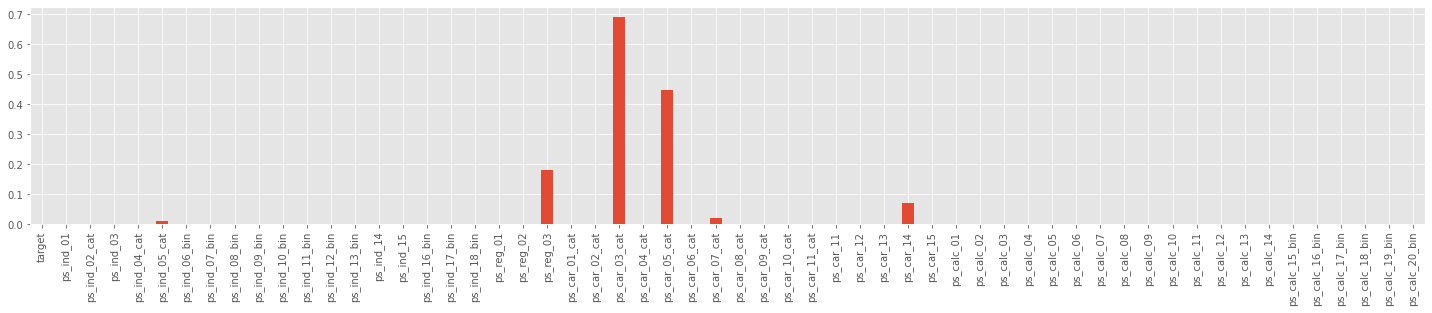

In [108]:
data1.isnull().mean().plot.bar(figsize=(25,4))
plt.show()

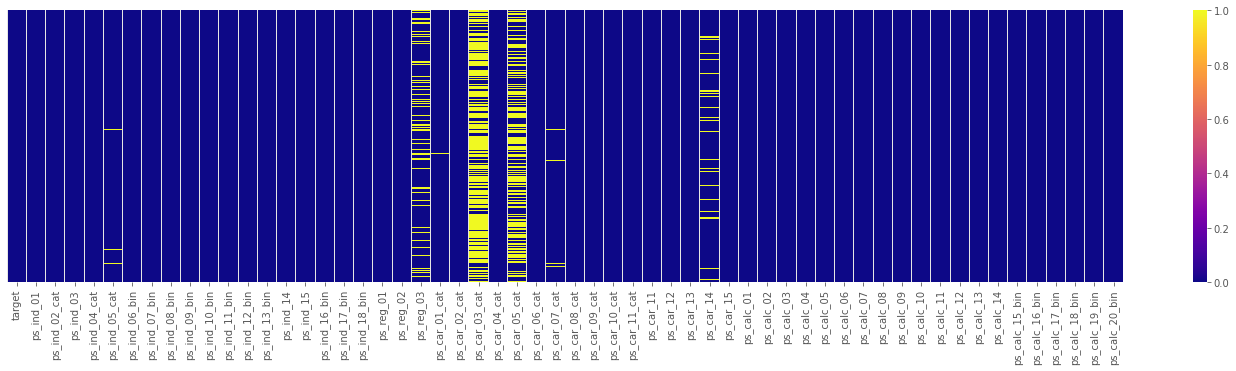

In [109]:
plt.figure(figsize=(25,5))
sns.heatmap(data1.isnull(),yticklabels=False,cmap='plasma')
plt.show()

**Strategy for Missing values**

- The percentage of missing values in the features **"ps_car_03_cat"** and **"ps_car_05_cat"** is very large.Hence dropping these feature columns.

- **ps_reg_03** and **ps_car_14** have 18.11 % and 7.16 % of missing values respectively, so imputing missing values on the basis of distribution. 

- For the remaining features, impute missing values by mean,median or mode. 

In [110]:
#Dropping "ps_car_03_cat" and "ps_car_05_cat"
data1=data1.drop(["ps_car_03_cat","ps_car_05_cat"],axis=1)
data1.shape

(595212, 56)

**Categorical features**
- From the visualizations of categorical features, it can be observe that the missing values in the features **ps_ind_05_cat and ps_car_07_cat** can be safely imputed with their respective modes.
- The missing values in the remaining features will be treated as a separate class in order to avoid any bias in the dataset.

In [0]:
data1['ps_ind_05_cat'].fillna(int(data1['ps_ind_05_cat'].mode()),inplace=True)
data1['ps_car_07_cat'].fillna(int(data1['ps_car_07_cat'].mode()),inplace=True)

In [0]:
data1['ps_ind_02_cat'].fillna(-1,inplace=True)
data1['ps_ind_04_cat'].fillna(-1,inplace=True)
data1['ps_car_01_cat'].fillna(-1,inplace=True)
data1['ps_car_09_cat'].fillna(-1,inplace=True)

**Interval Features**
- For ps_reg_03 first, we will analyse the distribution of the features before and after imputation.

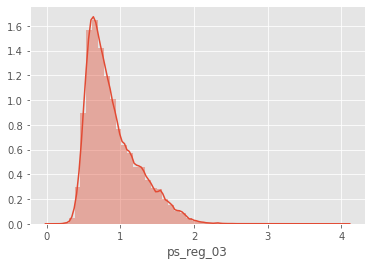

In [113]:
# Distribution of features before imputation.
sns.distplot(data1['ps_reg_03'])
plt.show()

In [0]:
reg_03_mean=data1['ps_reg_03'].fillna(data1['ps_reg_03'].mean())
reg_03_mode=data1['ps_reg_03'].fillna(0.633936)
reg_03_median=data1['ps_reg_03'].fillna(data1['ps_reg_03'].median())

**Selecting the best strategy for missing values imputation.**

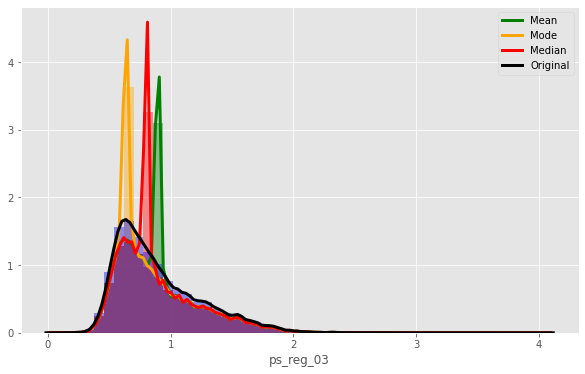

In [115]:
plt.figure(figsize=(10,6))
sns.distplot(reg_03_mean,color='green',kde_kws={"color": "g", "lw": 3,"label":"Mean"})
sns.distplot(reg_03_mode,color='orange',kde_kws={"color": "orange", "lw": 3,"label":"Mode"})
sns.distplot(reg_03_median,color='r',kde_kws={"color": "r", "lw": 3,"label":"Median"})
sns.distplot(data1['ps_reg_03'],color='blue',kde_kws={"color": "k", "lw": 3,"label":"Original"})
plt.show()

- By comparative analysis of different strategies with respect to the  original feature, it can be seen that the apex of the distribution has changed significantly in the vertical direction.
- In order to preserve the distribution, let's try fillna() method with ffill or bfill strategy.

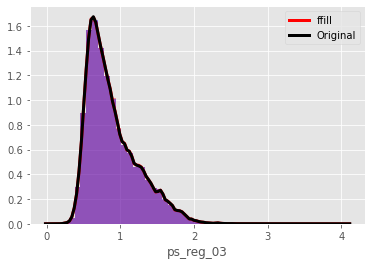

In [116]:
reg_03_ffill=data1['ps_reg_03'].fillna(method='ffill')
sns.distplot(reg_03_ffill,color='r',kde_kws={"color": "r", "lw": 3,"label":"ffill"})
sns.distplot(data1['ps_reg_03'],color='blue',kde_kws={"color": "k", "lw": 3,"label":"Original"})
plt.show()

- By using fillna() method, the distribution is completely preserved.

#### **2-Sample Kolmogorov–Smirnov test to check the similarity of distributions**

In [0]:
# Dropping null values for KS-test
ps_reg_03_dropped=data1['ps_reg_03'].dropna()
from scipy import stats
print(stats.ks_2samp(reg_03_mean,ps_reg_03_dropped,alternative='two-sided',mode='exact'))
print(stats.ks_2samp(reg_03_median,ps_reg_03_dropped,alternative='two-sided',mode='exact'))
print(stats.ks_2samp(reg_03_mode,ps_reg_03_dropped,alternative='two-sided',mode='exact'))
print(stats.ks_2samp(reg_03_ffill,ps_reg_03_dropped,alternative='two-sided',mode='exact'))

Ks_2sampResult(statistic=0.10930793980011037, pvalue=1.0)
Ks_2sampResult(statistic=0.09053133455988141, pvalue=1.0)
Ks_2sampResult(statistic=0.1357214095480126, pvalue=1.0)
Ks_2sampResult(statistic=0.0008336574692568939, pvalue=1.0)


Null Hypothesis.......**H0:** Distributions are same <br/>
Alternate Hypothesis **H1:** Distributions are different
- Surprisingly, from the KS-test the p-values of **mean,median and mode & ffill** comes out to be exact 1.0 which means that the distribution of the feature before and after imputation of missing values is same. Hence we accept the null hypothesis.

- However, in order to preserve the shape of the distribution the Fillna method with **ffill** strategy will be used.Therefore,imputing missing values with ffill (forward fill). 

In [0]:
data1['ps_reg_03'].fillna(method='ffill',inplace=True)

#### **Missing value imputation of ps_car_14 feature.**

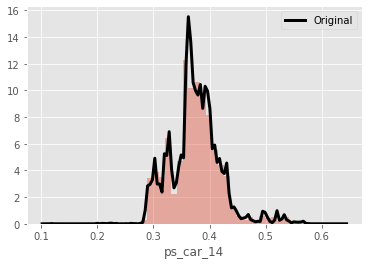

In [118]:
sns.distplot(data1['ps_car_14'],kde_kws={"color": "k", "lw": 3,"label":"Original"})
plt.show()

In [0]:
car_14_mean=data1['ps_car_14'].fillna(data1['ps_car_14'].mean())
car_14_median=data1['ps_car_14'].fillna(data1['ps_car_14'].median())
car_14_mode=data1['ps_car_14'].fillna(0.361525)
car_14_ffill=data1['ps_car_14'].fillna(method='ffill')

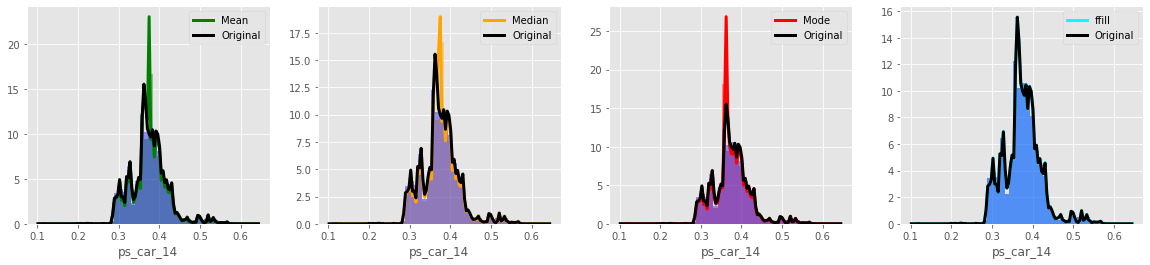

In [120]:
plt.subplots(1,4,figsize=(20,4))
plt.subplot(1,4,1)
sns.distplot(car_14_mean,color='green',kde_kws={"color": "green", "lw": 3,"label":"Mean"})
sns.distplot(data1['ps_car_14'],color='blue',kde_kws={"color": "k", "lw": 3,"label":"Original"})
plt.subplot(1,4,2)
sns.distplot(car_14_median,color='orange',kde_kws={"color": "orange", "lw": 3,"label":"Median"})
sns.distplot(data1['ps_car_14'],color='blue',kde_kws={"color": "k", "lw": 3,"label":"Original"})
plt.subplot(1,4,3)
sns.distplot(car_14_mode,color='red',kde_kws={"color": "red", "lw": 3,"label":"Mode"})
sns.distplot(data1['ps_car_14'],color='blue',kde_kws={"color": "k", "lw": 3,"label":"Original"})
plt.subplot(1,4,4)
sns.distplot(car_14_ffill,color='cyan',kde_kws={"color": "cyan", "lw": 3,"label":"ffill"})
sns.distplot(data1['ps_car_14'],color='blue',kde_kws={"color": "k", "lw": 3,"label":"Original"})
plt.show()


#### **2-Sample Kolmogorov–Smirnov test to check the similarity of distributions**

In [0]:
ps_car_14_dropped=data1['ps_car_14'].dropna()
print(stats.ks_2samp(car_14_mean,ps_car_14_dropped,mode='asymp'))
print(stats.ks_2samp(car_14_median,ps_car_14_dropped,mode='asymp'))
print(stats.ks_2samp(car_14_mode,ps_car_14_dropped,mode='asymp'))
print(stats.ks_2samp(car_14_ffill,ps_car_14_dropped,mode='asymp'))

Ks_2sampResult(statistic=0.03745723270040663, pvalue=0.0)
Ks_2sampResult(statistic=0.03568367451503618, pvalue=2.3552e-317)
Ks_2sampResult(statistic=0.04529110671624298, pvalue=0.0)
Ks_2sampResult(statistic=0.0002952186805807999, pvalue=1.0)


From the visualizations of the distributions and KS-test, it can be seen that filling the missing values with forward fill method in fillna(), best preserved the distribution of the feature with p-value as 1.0

In [0]:
# Imputing the missing values
data1['ps_car_14'].fillna(method='ffill',inplace=True)

In [0]:
# Imputing missing values of the remaining features with mode and mean respectively.
data1['ps_car_11'].fillna(int(data1['ps_car_11'].mode()),inplace=True)
data1['ps_car_12'].fillna(data1['ps_car_12'].mean(),inplace=True)

In [123]:
# Final check for missing values
data1.isna().sum().sum()

0

In [0]:
# Creating a copy of the dataset
data2=data1.copy()

#### **Restoring the original dtypes of the features.**

In [0]:
# Separating the data types into two categories
int_feat=[]
float_feat=[]
for i in data1.columns:
  if data[i].dtypes=='int64':
    int_feat.append(i)
  else:
    float_feat.append(i)

In [0]:
for i in int_feat:
  data2[i]=data2[i].astype('int64')
for i in float_feat:
  data2[i]=data2[i].astype('float64')

In [0]:
#data2.info()

In [0]:
# Splitting the columns
categorical=[]
binary=[]
interval=[]
ordinal=[]
target=[]
for i in data2.columns:
  if 'cat' in i:
    categorical.append(i)
  elif 'bin' in i:
    binary.append(i)
  elif data2[i].dtype==float:
    interval.append(i)
  elif (data2[i].dtype==int and i!='target'):
    ordinal.append(i)
  elif i == 'target':
    target.append(i)

### **One Hot Encoding of Categorical Variables**

In [0]:
dummy_df=pd.DataFrame()
for i in range(len(categorical)):
  dummy=pd.get_dummies(data2[categorical[i]],prefix=categorical[i],drop_first=True,dtype='int64')
  for i in range(len(dummy.columns)):
    dummy_df[dummy.columns[i]]=dummy.iloc[:,i]

In [130]:
dummy_df.head(2)

,ps_ind_02_cat_1,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,ps_ind_04_cat_0,ps_ind_04_cat_1,ps_ind_05_cat_1,ps_ind_05_cat_2,ps_ind_05_cat_3,ps_ind_05_cat_4,ps_ind_05_cat_5,ps_ind_05_cat_6,ps_car_01_cat_0,ps_car_01_cat_1,ps_car_01_cat_2,ps_car_01_cat_3,ps_car_01_cat_4,ps_car_01_cat_5,ps_car_01_cat_6,ps_car_01_cat_7,ps_car_01_cat_8,ps_car_01_cat_9,ps_car_01_cat_10,ps_car_01_cat_11,ps_car_02_cat_1,ps_car_04_cat_1,ps_car_04_cat_2,ps_car_04_cat_3,ps_car_04_cat_4,ps_car_04_cat_5,ps_car_04_cat_6,ps_car_04_cat_7,ps_car_04_cat_8,ps_car_04_cat_9,ps_car_06_cat_1,ps_car_06_cat_2,ps_car_06_cat_3,ps_car_06_cat_4,ps_car_06_cat_5,ps_car_06_cat_6,...,ps_car_11_cat_65,ps_car_11_cat_66,ps_car_11_cat_67,ps_car_11_cat_68,ps_car_11_cat_69,ps_car_11_cat_70,ps_car_11_cat_71,ps_car_11_cat_72,ps_car_11_cat_73,ps_car_11_cat_74,ps_car_11_cat_75,ps_car_11_cat_76,ps_car_11_cat_77,ps_car_11_cat_78,ps_car_11_cat_79,ps_car_11_cat_80,ps_car_11_cat_81,ps_car_11_cat_82,ps_car_11_cat_83,ps_car_11_cat_84,ps_car_11_cat_85,ps_car_11_cat_86,ps_car_11_cat_87,ps_car_11_cat_88,ps_car_11_cat_89,ps_car_11_cat_90,ps_car_11_cat_91,ps_car_11_cat_92,ps_car_11_cat_93,ps_car_11_cat_94,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Scaling of Interval and Ordinal features**

In [131]:
scaler=MinMaxScaler()
interval_scaled=scaler.fit_transform(data2[interval])
interval_scaled=pd.DataFrame(interval_scaled,columns=interval)
interval_scaled.head(2)

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
0,0.777778,0.111111,0.165170,0.257530,0.182438,0.495899,0.963624,0.666667,0.555556,0.222222
1,0.888889,0.222222,0.177242,0.185617,0.106109,0.529886,0.654654,0.333333,0.111111,0.333333


In [132]:
ordinal_scaled=scaler.fit_transform(data2[ordinal])
ordinal_scaled=pd.DataFrame(ordinal_scaled,columns=ordinal)
ordinal_scaled.head(2)

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
0,0.285714,0.454545,0.0,0.846154,0.666667,0.6,0.166667,1.0,0.111111,0.8,0.142857,0.20,0.473684,0.1,0.384615,0.347826
1,0.142857,0.636364,0.0,0.230769,1.000000,0.4,0.166667,0.9,0.555556,0.6,0.142857,0.28,0.157895,0.1,0.076923,0.391304


### **Merging all the features**

In [133]:
data3=pd.concat([data2['target'],interval_scaled,ordinal_scaled,dummy_df,data2[binary]],axis=1)
data3.head(2)

,target,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_ind_02_cat_1,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,ps_ind_04_cat_0,ps_ind_04_cat_1,ps_ind_05_cat_1,ps_ind_05_cat_2,ps_ind_05_cat_3,ps_ind_05_cat_4,ps_ind_05_cat_5,ps_ind_05_cat_6,ps_car_01_cat_0,...,ps_car_11_cat_82,ps_car_11_cat_83,ps_car_11_cat_84,ps_car_11_cat_85,ps_car_11_cat_86,ps_car_11_cat_87,ps_car_11_cat_88,ps_car_11_cat_89,ps_car_11_cat_90,ps_car_11_cat_91,ps_car_11_cat_92,ps_car_11_cat_93,ps_car_11_cat_94,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0.777778,0.111111,0.165170,0.257530,0.182438,0.495899,0.963624,0.666667,0.555556,0.222222,0.285714,0.454545,0.0,0.846154,0.666667,0.6,0.166667,1.0,0.111111,0.8,0.142857,0.20,0.473684,0.1,0.384615,0.347826,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1
1,0,0.888889,0.222222,0.177242,0.185617,0.106109,0.529886,0.654654,0.333333,0.111111,0.333333,0.142857,0.636364,0.0,0.230769,1.000000,0.4,0.166667,0.9,0.555556,0.6,0.142857,0.28,0.157895,0.1,0.076923,0.391304,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0


After One-Hot encoding, the total number of columns have rose to 207.

### **BALANCING DATA**

In [134]:
data['target'].groupby(data['target']).count()

target
0    573518
1     21694
Name: target, dtype: int64

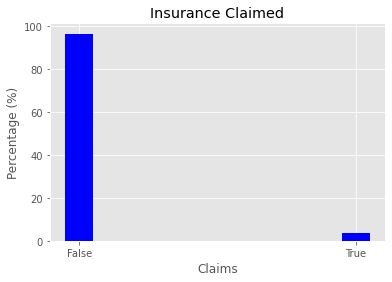

%
target
0    96.36
1     3.64
Name: target, dtype: float64


In [135]:
# Checking the proportion of the target
x=round(data['target'].groupby(data['target']).count()*100/len(data['target']),2)
plt.bar(data['target'].unique(),x,width=0.1,color='blue')
plt.xticks(data['target'].unique(),['False','True'])
plt.xlabel("Claims")
plt.ylabel("Percentage (%)")
plt.title("Insurance Claimed")
plt.show()
print('%')
print(x)

- It can be seen that the dataset is highly imbalanced. The percentage of insurance claimed is just **3.64 %** of overall claims.
- In order to balance the data we need to perform **oversampling**.

In [0]:
X=data3.drop(['target'],axis=1)
Y=data3['target']

In [0]:
from imblearn.over_sampling import RandomOverSampler
ros=RandomOverSampler(ratio=1)
X_train_res,y_train_res=ros.fit_sample(X,Y)

In [138]:
# Oversampled data with one-hot encoded
X_train_res.shape,y_train_res.shape

((1147036, 206), (1147036,))

In [0]:
X_train_res=pd.DataFrame(X_train_res,columns=X.columns)
y_train_res=pd.DataFrame(y_train_res,columns=['target'])

In [140]:
from collections import Counter
print('Original dataset shape: {}'.format(Counter(Y)))
print('Resampled dataset shape: {}'.format(Counter(y_train_res)))

Original dataset shape: Counter({0: 573518, 1: 21694})
Resampled dataset shape: Counter({'target': 1})


In [141]:
# Oversampling the data without one-hot encoding and scaling
data2_X = data2.drop('target',axis=1)
data2_Y=data2['target']
ros1=RandomOverSampler(ratio=1)
X_train3_res,Y_train3_res=ros.fit_sample(data2_X,data2_Y)
X_train3_res=pd.DataFrame(X_train3_res,columns=data2_X.columns)
Y_train3_res=pd.DataFrame(Y_train3_res,columns=['target'])
X_train3_res.shape,Y_train3_res.shape

((1147036, 55), (1147036, 1))

### **CORRELATION PLOTS** 

In [142]:
# Interval
corr = data2[['target','ps_reg_03','ps_car_12','ps_car_13','ps_car_14','ps_reg_01','ps_reg_02']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,target,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_reg_01,ps_reg_02
target,1.00,0.03,0.04,0.05,0.01,0.02,0.03
ps_reg_03,0.03,1.00,0.18,0.22,0.07,0.12,0.64
ps_car_12,0.04,0.18,1.00,0.67,0.56,0.02,0.17
ps_car_13,0.05,0.22,0.67,1.00,0.42,0.03,0.19
ps_car_14,0.01,0.07,0.56,0.42,1.00,-0.00,0.05
ps_reg_01,0.02,0.12,0.02,0.03,-0.00,1.00,0.47
ps_reg_02,0.03,0.64,0.17,0.19,0.05,0.47,1.00


- There is a good correlation between **ps_reg_03** and **ps_reg_02**.
- The **ps_car_12** showing moderate correlation with **ps_reg_02 and 03** and strong correlation with **ps_car_12 and 14**. 

In [143]:
# ORDINAL
corr1=data2[['target','ps_car_11','ps_ind_01','ps_ind_03','ps_ind_14','ps_ind_15']].corr()
corr1.style.background_gradient(cmap='coolwarm').set_precision(2)

,target,ps_car_11,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15
target,1.00,-0.00,0.02,0.01,0.01,-0.02
ps_car_11,-0.00,1.00,0.01,-0.06,0.00,0.02
ps_ind_01,0.02,0.01,1.00,0.22,-0.02,0.12
ps_ind_03,0.01,-0.06,0.22,1.00,0.00,0.17
ps_ind_14,0.01,0.00,-0.02,0.00,1.00,-0.12
ps_ind_15,-0.02,0.02,0.12,0.17,-0.12,1.00


**ps_ind_03** showing moderate correlation with **ps_ind_01**.

In [144]:
# BINARY
corr3=data2[['target','ps_ind_06_bin','ps_ind_07_bin','ps_ind_08_bin','ps_ind_09_bin',
             'ps_ind_10_bin','ps_ind_11_bin','ps_ind_12_bin','ps_ind_13_bin','ps_ind_16_bin','ps_ind_17_bin','ps_ind_18_bin']].corr()
corr3.style.background_gradient(cmap='coolwarm').set_precision(2)

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin
target,1.00,-0.03,0.03,0.01,-0.01,0.00,0.00,0.01,0.00,-0.03,0.04,0.00
ps_ind_06_bin,-0.03,1.00,-0.47,-0.36,-0.38,-0.01,-0.01,-0.02,-0.01,0.03,-0.04,-0.01
ps_ind_07_bin,0.03,-0.47,1.00,-0.26,-0.28,0.01,0.01,0.04,0.01,-0.07,0.02,0.08
ps_ind_08_bin,0.01,-0.36,-0.26,1.00,-0.21,0.01,0.01,0.01,0.01,0.01,0.04,-0.03
ps_ind_09_bin,-0.01,-0.38,-0.28,-0.21,1.00,-0.01,-0.01,-0.03,-0.01,0.04,-0.01,-0.04
ps_ind_10_bin,0.00,-0.01,0.01,0.01,-0.01,1.00,0.06,0.10,0.08,-0.02,0.01,0.03
ps_ind_11_bin,0.00,-0.01,0.01,0.01,-0.01,0.06,1.00,0.25,0.18,-0.05,0.00,0.07
ps_ind_12_bin,0.01,-0.02,0.04,0.01,-0.03,0.10,0.25,1.00,0.15,-0.10,0.03,0.11
ps_ind_13_bin,0.00,-0.01,0.01,0.01,-0.01,0.08,0.18,0.15,1.00,-0.04,0.00,0.05
ps_ind_16_bin,-0.03,0.03,-0.07,0.01,0.04,-0.02,-0.05,-0.10,-0.04,1.00,-0.52,-0.59


- In binary features **ps_ind_07_bin** showing negative correlation with **ps_ind_06_bin**.
- **ps_ind_08_bin and 09_bin** showing negative correlation with **ps_ind_06_bin,07_bin & 08_bin**.
- **ps_ind_18_bin and ps_ind_17_bin** showing maximum correlation with **ps_ind_16_bin**.

In [145]:
# CATEGORICAL
corr4=data2[['target','ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat','ps_car_01_cat','ps_car_02_cat','ps_car_04_cat',
 'ps_car_06_cat','ps_car_07_cat','ps_car_08_cat','ps_car_09_cat','ps_car_10_cat','ps_car_11_cat']].corr()
corr4.style.background_gradient(cmap='coolwarm').set_precision(2)

,target,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat
target,1.00,0.00,0.01,0.03,0.02,-0.03,0.03,0.01,-0.02,-0.02,0.01,0.00,0.01
ps_ind_02_cat,0.00,1.00,0.15,-0.01,0.00,0.05,-0.07,-0.02,0.02,0.00,0.01,0.01,0.01
ps_ind_04_cat,0.01,0.15,1.00,0.01,0.03,0.00,-0.05,0.03,0.08,-0.01,-0.04,0.02,-0.00
ps_ind_05_cat,0.03,-0.01,0.01,1.00,-0.04,0.01,-0.01,-0.01,0.00,-0.00,-0.01,0.00,-0.00
ps_car_01_cat,0.02,0.00,0.03,-0.04,1.00,-0.15,0.07,0.05,0.08,-0.06,0.27,0.01,0.01
ps_car_02_cat,-0.03,0.05,0.00,0.01,-0.15,1.00,-0.27,-0.25,-0.02,0.04,-0.01,-0.02,-0.00
ps_car_04_cat,0.03,-0.07,-0.05,-0.01,0.07,-0.27,1.00,0.19,-0.04,-0.05,-0.04,0.00,0.07
ps_car_06_cat,0.01,-0.02,0.03,-0.01,0.05,-0.25,0.19,1.00,0.01,-0.01,0.00,-0.00,0.03
ps_car_07_cat,-0.02,0.02,0.08,0.00,0.08,-0.02,-0.04,0.01,1.00,-0.00,0.00,0.02,-0.03
ps_car_08_cat,-0.02,0.00,-0.01,-0.00,-0.06,0.04,-0.05,-0.01,-0.00,1.00,-0.02,-0.03,0.03


- The categorical features doesn't have much coorelation among one another except between **ps_car_02_cat and, ps_car_04_cat and ps_car_06_cat**.

### **Significance Test for the Correlation**
- Null Hypothesis.......**H0:** No correlation
- Alternate Hypothesis **H1:** Correlation exists

In [0]:
# Defining function for hypothesis testing
def corr_test(feat1,feat2,alpha):
  df=len(data2[feat1])-2
  alpha=1-(alpha/2)
  t1=stats.t.ppf(alpha,df)
  r=stats.pearsonr(data2[feat1],data2[feat2])[0]
  n=len(data2[feat1])
  t2=r/np.sqrt((1-(r*r))/df)
  print(feat1,feat2)
  if t1>t2 or t1<-t2:
    print('Correlation Exists ! Reject the Null Hypothesis')
  else:
    print('No Correlation ! Accept the Null Hypothesis')
  print('')

In [147]:
corr_test('ps_reg_03','ps_reg_02',0.05)
corr_test('ps_car_12','ps_reg_02',0.05)
corr_test('ps_car_12','ps_reg_03',0.05)
corr_test('ps_car_12','ps_car_12',0.05)
corr_test('ps_car_12','ps_car_14',0.05)
corr_test('ps_ind_03','ps_ind_01',0.05)
corr_test('ps_ind_07_bin','ps_ind_06_bin',0.05)
corr_test('ps_ind_08_bin','ps_ind_06_bin',0.05)
corr_test('ps_ind_09_bin','ps_ind_07_bin',0.05)
corr_test('ps_ind_18_bin','ps_ind_16_bin',0.05)
corr_test('ps_ind_17_bin','ps_ind_16_bin',0.05)
corr_test('ps_car_02_cat','ps_car_04_cat',0.05)
corr_test('ps_car_02_cat','ps_car_06_cat',0.05)
corr_test('ps_car_04_cat','ps_car_06_cat',0.05)

ps_reg_03 ps_reg_02
No Correlation ! Accept the Null Hypothesis

ps_car_12 ps_reg_02
No Correlation ! Accept the Null Hypothesis

ps_car_12 ps_reg_03
No Correlation ! Accept the Null Hypothesis

ps_car_12 ps_car_12
No Correlation ! Accept the Null Hypothesis

ps_car_12 ps_car_14
No Correlation ! Accept the Null Hypothesis

ps_ind_03 ps_ind_01
No Correlation ! Accept the Null Hypothesis

ps_ind_07_bin ps_ind_06_bin
Correlation Exists ! Reject the Null Hypothesis

ps_ind_08_bin ps_ind_06_bin
Correlation Exists ! Reject the Null Hypothesis

ps_ind_09_bin ps_ind_07_bin
Correlation Exists ! Reject the Null Hypothesis

ps_ind_18_bin ps_ind_16_bin
Correlation Exists ! Reject the Null Hypothesis

ps_ind_17_bin ps_ind_16_bin
Correlation Exists ! Reject the Null Hypothesis

ps_car_02_cat ps_car_04_cat
Correlation Exists ! Reject the Null Hypothesis

ps_car_02_cat ps_car_06_cat
Correlation Exists ! Reject the Null Hypothesis

ps_car_04_cat ps_car_06_cat
No Correlation ! Accept the Null Hypothesis

**From the above result, it is verified whether correlation between two features exists or not!**

### **EDA SUMMARY**

- In EDA, we analyzed the distribution of each feature category and its impact on insurance claims. In interval features, we observed that the distribution and claimed percentage distribution is almost same except for ps_reg_01 and ps_car_15 that show higher claim percentage.
Some of the categorical and binary features show very high claim percentage but on the other hand those features were found out to be imbalanced.
- In most of the features, the claim rates are almost proportional to their original distribution with small difference in terms of percentages.The **ind** features have more impact on claims whereas the calc binary and interval features have very low impact and hence will not be able to help in prediction.

### **FEATURE SELECTION**

#### **Univariate Selection**

In [148]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

best_features=SelectKBest(k=50,score_func=chi2)
fit=best_features.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['X','Score']
featureScores=featureScores.sort_values(by='Score',ascending=False)
featureScores.head()

,X,Score
198,ps_ind_17_bin,718.220742
190,ps_ind_07_bin,517.788573
189,ps_ind_06_bin,417.558962
59,ps_car_04_cat_9,350.816582
80,ps_car_09_cat_1,347.944131


In [149]:
selected_features=X_train_res[featureScores['X'][:]]
selected_features.head(2)

,ps_ind_17_bin,ps_ind_07_bin,ps_ind_06_bin,ps_car_04_cat_9,ps_car_09_cat_1,ps_ind_05_cat_6,ps_car_01_cat_7,ps_car_01_cat_9,ps_ind_05_cat_2,ps_car_11_cat_104,ps_car_06_cat_9,ps_ind_16_bin,ps_car_01_cat_11,ps_reg_02,ps_car_04_cat_1,ps_car_11_cat_41,ps_car_06_cat_15,ps_ind_05_cat_4,ps_car_04_cat_8,ps_car_06_cat_17,ps_car_02_cat_1,ps_ind_08_bin,ps_car_06_cat_11,ps_car_01_cat_6,ps_car_04_cat_2,ps_car_06_cat_13,ps_car_11_cat_103,ps_car_11_cat_99,ps_ind_01,ps_car_06_cat_10,ps_car_09_cat_0,ps_car_11_cat_32,ps_reg_01,ps_car_13,ps_car_11_cat_55,ps_car_06_cat_8,ps_car_08_cat_1,ps_car_11_cat_93,ps_car_06_cat_2,ps_car_11_cat_64,...,ps_calc_03,ps_car_11_cat_102,ps_car_01_cat_10,ps_car_11_cat_76,ps_calc_01,ps_car_11_cat_70,ps_car_01_cat_3,ps_calc_02,ps_car_11_cat_27,ps_car_11_cat_23,ps_car_11_cat_2,ps_car_09_cat_2,ps_calc_18_bin,ps_calc_15_bin,ps_car_11_cat_51,ps_car_11_cat_15,ps_car_11,ps_calc_16_bin,ps_calc_12,ps_car_11_cat_8,ps_car_06_cat_6,ps_car_10_cat_2,ps_calc_14,ps_calc_05,ps_car_11_cat_6,ps_calc_09,ps_calc_10,ps_calc_08,ps_calc_13,ps_car_11_cat_73,ps_calc_17_bin,ps_car_11_cat_92,ps_calc_11,ps_car_10_cat_1,ps_car_11_cat_59,ps_car_11_cat_29,ps_car_11_cat_34,ps_calc_07,ps_calc_06,ps_calc_04
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714,0.0,1.0,0.0,0.777778,0.182438,0.0,0.0,0.0,0.0,0.0,0.0,...,0.222222,0.0,1.0,0.0,0.666667,0.0,0.0,0.555556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,1.0,0.1,0.0,0.0,0.0,0.347826,0.166667,0.0,0.142857,0.20,0.8,0.384615,0.0,1.0,0.0,0.473684,1.0,0.0,0.0,0.0,0.111111,1.0,0.6
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.888889,0.106109,0.0,0.0,1.0,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.0,0.333333,0.0,0.0,0.111111,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,1.0,0.1,0.0,0.0,0.0,0.391304,0.166667,0.0,0.142857,0.28,0.6,0.076923,0.0,1.0,0.0,0.157895,1.0,0.0,0.0,0.0,0.555556,0.9,0.4


#### **Feature Importance**

In [150]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()
etc.fit(X,Y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

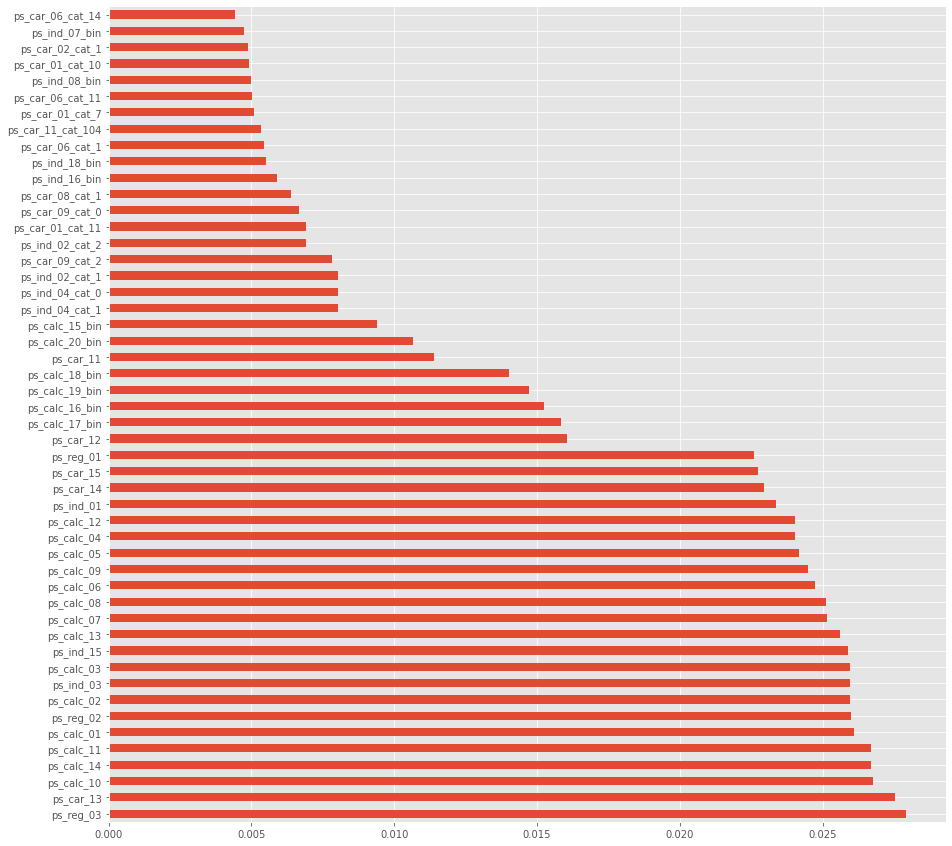

In [151]:
plt.figure(figsize=(15,15))
feat_importances = pd.Series(etc.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')
plt.show()

In [0]:
imp_features=pd.DataFrame(etc.feature_importances_)
imp_features_cols=pd.DataFrame(etc.feature_importances_,index=X.columns,columns=['importance'])
imp_features_cols=imp_features_cols['importance'].sort_values(ascending=False)
imp_features=imp_features_cols.index.to_list()

## **MODELLING**

In [0]:
def metrics(test,pred):
  print('ACCURACY=',accuracy_score(test,pred))
  print('BALANCED ACCURACY=',balanced_accuracy_score(test,pred))
  print('F1_SCORE=',f1_score(test,pred))
  print('CONFUSION MATRIX')
  print(confusion_matrix(test,pred))
  print(classification_report(test,pred))

**Model 1: Logistic Regression with Imbalanced data**

In [0]:
X=data2.drop('target',axis=1)
Y=data2['target']
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30)
clf=LogisticRegression()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
metrics(y_test,y_pred)

ACCURACY= 0.9637552922201563
BALANCED ACCURACY= 0.5
F1_SCORE= 0.0
CONFUSION MATRIX
[[172092      0]
 [  6472      0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    172092
           1       0.00      0.00      0.00      6472

    accuracy                           0.96    178564
   macro avg       0.48      0.50      0.49    178564
weighted avg       0.93      0.96      0.95    178564



Although accuracy of the model is 96%, the F1-score is Zero. It is because the data is highly unbalanced with very few claimed data.

**Model 2: Logistic Regression with Imbalanced data + One-Hot encoded+ Scaled data**

In [0]:
X=data3.drop('target',axis=1)
Y=data3['target']
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30)
clf=LogisticRegression()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
metrics(y_test,y_pred)

ACCURACY= 0.9631560672923993
BALANCED ACCURACY= 0.5
F1_SCORE= 0.0
CONFUSION MATRIX
[[171985      0]
 [  6579      0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    171985
           1       0.00      0.00      0.00      6579

    accuracy                           0.96    178564
   macro avg       0.48      0.50      0.49    178564
weighted avg       0.93      0.96      0.95    178564



As we can see here that even after encoding the categorical variables still there is no change in the result. The model is correctly classifying the Zeros and incorrectly classifying the Ones. Therefore,F1 score is still Zero.

**Model 3: Logistic Regression with Balanced data**

In [0]:
X_train3_res.shape,Y_train3_res.shape

((1147036, 55), (1147036, 1))

In [0]:
X_train,X_test,y_train,y_test=train_test_split(X_train3_res,Y_train3_res,test_size=0.30)
clf=LogisticRegression()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
metrics(y_test,y_pred)
Counter(y_test)

ACCURACY= 0.5835035787870774
BALANCED ACCURACY= 0.5835108947217937
F1_SCORE= 0.5656215429844367
CONFUSION MATRIX
[[107478  64547]
 [ 78774  93312]]
              precision    recall  f1-score   support

           0       0.58      0.62      0.60    172025
           1       0.59      0.54      0.57    172086

    accuracy                           0.58    344111
   macro avg       0.58      0.58      0.58    344111
weighted avg       0.58      0.58      0.58    344111



Counter({'target': 1})

It can be seen that the data balancing has a positive impact on the result. The f1-score has increased from zero to 0.57.

**MODEL 3 WITH GRIDSEARCH CV**

In [0]:
X_train,X_test,y_train,y_test=train_test_split(X_train_res,y_train_res,test_size=0.30)
clf=LogisticRegression()
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
clf=GridSearchCV(clf,grid,cv=10)
clf.fit(X_train,y_train)
print("tuned hpyerparameters :(best parameters) ",clf.best_params_)
print("accuracy :",clf.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.5950456178378607


Still not much improvement in the accuracy. The logistic regression doesn't works well with datasets having large number of features.

**Model 4: Logistic Regression with Balanced data + One-Hot encoded+ Scaled data**

In [0]:
X_train,X_test,y_train,y_test=train_test_split(X_train_res,y_train_res,test_size=0.30)
clf=LogisticRegression()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
metrics(y_test,y_pred)
Counter(y_test)

ACCURACY= 0.5951132047507927
BALANCED ACCURACY= 0.5951003226324498
F1_SCORE= 0.5829187247418052
CONFUSION MATRIX
[[107423  64709]
 [ 74617  97362]]
              precision    recall  f1-score   support

           0       0.59      0.62      0.61    172132
           1       0.60      0.57      0.58    171979

    accuracy                           0.60    344111
   macro avg       0.60      0.60      0.59    344111
weighted avg       0.60      0.60      0.59    344111



Counter({'target': 1})

There is not much change in the result after encoding the categorical variables and scaling the data. The accuracy of the model just increased from 58% to 59% whereas F1 score of One increased from 0.58 to 0.59.It maybe due to the curse of dimensionality. Therefore, instead of using all the features we need to select some best featutes.

**MODEL 4 WITH GRIDSEARCH CV**

In [0]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
clf4_1=LogisticRegression()
clf4_cv=GridSearchCV(clf4_1,grid,cv=10)
clf4_cv.fit(X_train4,y_train4)
print("tuned hpyerparameters :(best parameters) ",clf4_cv.best_params_)
print("accuracy :",clf4_cv.best_score_)

'\ngrid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}\nclf4_1=LogisticRegression()\nclf4_cv=GridSearchCV(clf4_1,grid,cv=10)\nclf4_cv.fit(X_train4,y_train4)\nprint("tuned hpyerparameters :(best parameters) ",clf4_cv.best_params_)\nprint("accuracy :",clf4_cv.best_score_)\n'

**Linear_SVC IMBALANCED**

In [0]:
X=data2.drop('target',axis=1)
Y=data2['target']
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30)
lsvc=LinearSVC(penalty='l1', dual=False,max_iter=2000)
lsvc.fit(X_train,y_train)
y_pred=lsvc.predict(X_test)
metrics(y_test,y_pred)
Counter(y_test)

ACCURACY= 0.9642873143522771
BALANCED ACCURACY= 0.5
F1_SCORE= 0.0
CONFUSION MATRIX
[[172187      0]
 [  6377      0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    172187
           1       0.00      0.00      0.00      6377

    accuracy                           0.96    178564
   macro avg       0.48      0.50      0.49    178564
weighted avg       0.93      0.96      0.95    178564



Counter({0: 172187, 1: 6377})

**Linear_SVC with sample of BALANCED data**

In [0]:
temp=pd.concat([X_train3_res,Y_train3_res],axis=1)
temp1=temp.sample(300000,random_state=42)
X=temp1.drop('target',axis=1)
Y=temp1['target']
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30)
lsvc=LinearSVC(penalty='l1', dual=False,max_iter=2000)
lsvc.fit(X_train,y_train)
y_pred=lsvc.predict(X_test)
metrics(y_test,y_pred)
Counter(y_test)

ACCURACY= 0.5860888888888889
BALANCED ACCURACY= 0.585948099389465
F1_SCORE= 0.5689822742629704
CONFUSION MATRIX
[[28160 17009]
 [20243 24588]]
              precision    recall  f1-score   support

           0       0.58      0.62      0.60     45169
           1       0.59      0.55      0.57     44831

    accuracy                           0.59     90000
   macro avg       0.59      0.59      0.59     90000
weighted avg       0.59      0.59      0.59     90000



Counter({0: 45169, 1: 44831})

On testing this model on various sample size,it was found that after increasing the number of records beyond 300K, the f1-score is not improving further.

**Linear_SVC with important features**

In [0]:
for i in np.arange(10,200,10):
  temp=pd.concat([X_train_res[imp_features[:i]],y_train_res],axis=1)
  temp1=temp.sample(220000,random_state=42)
  X=temp1.drop('target',axis=1)
  Y=temp1['target']
  X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30)
  lsvc=LinearSVC(penalty='l1', dual=False,max_iter=5000)
  lsvc.fit(X_train,y_train)
  y_pred=lsvc.predict(X_test)
  print(i,'','F1_SCORE=',f1_score(y_test, y_pred))

10  F1_SCORE= 0.5080791468149681
20  F1_SCORE= 0.5295758928571428
30  F1_SCORE= 0.550552573413325
40  F1_SCORE= 0.5574800663140443
50  F1_SCORE= 0.5704122070708647
60  F1_SCORE= 0.572330203786856
70  F1_SCORE= 0.5723159388302065
80  F1_SCORE= 0.5711665269849302
90  F1_SCORE= 0.5720005674921576
100  F1_SCORE= 0.5747195354781703
110  F1_SCORE= 0.5780305053329352
120  F1_SCORE= 0.5785979944447059
130  F1_SCORE= 0.5785926379789792
140  F1_SCORE= 0.5771183253948358
150  F1_SCORE= 0.5782170749721074
160  F1_SCORE= 0.5749980331995909
170  F1_SCORE= 0.5791544526828962
180  F1_SCORE= 0.5807298585606001
190  F1_SCORE= 0.5818204621703822


### **Support Vector Classifier with sample**

In [75]:
temp=pd.concat([X_train3_res,Y_train3_res],axis=1)
temp1=temp.sample(100000,random_state=42)
X=temp1.drop('target',axis=1)
Y=temp1['target']
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30)
clf=SVC()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
metrics(y_test,y_pred)
Counter(y_test)

ACCURACY= 0.5808333333333333
BALANCED ACCURACY= 0.5810887779329271
F1_SCORE= 0.5244847797315183
CONFUSION MATRIX
[[10490  4478]
 [ 8097  6935]]
              precision    recall  f1-score   support

           0       0.56      0.70      0.63     14968
           1       0.61      0.46      0.52     15032

    accuracy                           0.58     30000
   macro avg       0.59      0.58      0.57     30000
weighted avg       0.59      0.58      0.57     30000



Counter({0: 14968, 1: 15032})

### **SVC+IMBALANCED**

In [76]:
sample=data2.sample(100000,random_state=42)
X=sample.drop('target',axis=1)
Y=sample['target']
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30)
clf=SVC()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
metrics(y_test,y_pred)
Counter(y_test)

ACCURACY= 0.9626333333333333
BALANCED ACCURACY= 0.5
F1_SCORE= 0.0
CONFUSION MATRIX
[[28879     0]
 [ 1121     0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     28879
           1       0.00      0.00      0.00      1121

    accuracy                           0.96     30000
   macro avg       0.48      0.50      0.49     30000
weighted avg       0.93      0.96      0.94     30000



Counter({0: 28879, 1: 1121})

### **XGBoost Classifier**

1) XGB with Imbalanced data

In [161]:
clf=xgboost.XGBClassifier()
X=data2.drop('target',axis=1)
Y=data2['target']
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
metrics(y_test,y_pred)
Counter(y_test)

ACCURACY= 0.9632568714858538
BALANCED ACCURACY= 0.5
F1_SCORE= 0.0
CONFUSION MATRIX
[[172003      0]
 [  6561      0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    172003
           1       0.00      0.00      0.00      6561

    accuracy                           0.96    178564
   macro avg       0.48      0.50      0.49    178564
weighted avg       0.93      0.96      0.95    178564



Counter({0: 172003, 1: 6561})

2) XGB with Imbalanced One hot encoded dataset

In [170]:
clf=xgboost.XGBClassifier()
X=data3.drop('target',axis=1)
Y=data3['target']
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
metrics(y_test,y_pred)
Counter(y_test)

ACCURACY= 0.9636656884926413
BALANCED ACCURACY= 0.5
F1_SCORE= 0.0
CONFUSION MATRIX
[[172076      0]
 [  6488      0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    172076
           1       0.00      0.00      0.00      6488

    accuracy                           0.96    178564
   macro avg       0.48      0.50      0.49    178564
weighted avg       0.93      0.96      0.95    178564



Counter({0: 172076, 1: 6488})

3) XGB with Balanced dataset

In [174]:
X_train3_res.shape

(1147036, 55)

In [175]:
clf=xgboost.XGBClassifier()
X_train,X_test,y_train,y_test=train_test_split(X_train3_res,Y_train3_res,test_size=0.30)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
metrics(y_test,y_pred)
Counter(y_test)

ACCURACY= 0.6051419454768955
BALANCED ACCURACY= 0.6051302041718727
F1_SCORE= 0.5957893672151338
CONFUSION MATRIX
[[108099  64045]
 [ 71830 100137]]
              precision    recall  f1-score   support

           0       0.60      0.63      0.61    172144
           1       0.61      0.58      0.60    171967

    accuracy                           0.61    344111
   macro avg       0.61      0.61      0.60    344111
weighted avg       0.61      0.61      0.60    344111



Counter({'target': 1})

4) XGB with Balanced One Hot encoded dataset

In [176]:
X_train_res.shape

(1147036, 206)

In [177]:
clf=xgboost.XGBClassifier()
X_train,X_test,y_train,y_test=train_test_split(X_train_res,y_train_res,test_size=0.30)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
metrics(y_test,y_pred)
Counter(y_test)

ACCURACY= 0.6050257039153064
BALANCED ACCURACY= 0.604990715268462
F1_SCORE= 0.5946574652037374
CONFUSION MATRIX
[[108499  63800]
 [ 72115  99697]]
              precision    recall  f1-score   support

           0       0.60      0.63      0.61    172299
           1       0.61      0.58      0.59    171812

    accuracy                           0.61    344111
   macro avg       0.61      0.60      0.60    344111
weighted avg       0.61      0.61      0.60    344111



Counter({'target': 1})

5) Hypertuning XGBoost

In [0]:
## Hyper Parameter Optimization

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [0]:
classifier=xgboost.XGBClassifier()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
random_search.fit(X_train_res[imp_features[:20]],y_train_res)
random_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 15.3min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.2,
              learning_rate=0.25, max_delta_step=0, max_depth=10,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
classifier=xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.4,
              learning_rate=0.2, max_delta_step=0, max_depth=15,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
score=cross_val_score(classifier,X_train_res[imp_features[:20]],y_train_res,cv=10)

In [0]:
score.mean()

0.9915774218015464

6) XGBoost Model for first 'n' important features

In [0]:
for i in np.arange(10,200,10):
  temp=pd.concat([X_train_res[imp_features[:i]],y_train_res],axis=1)
  temp1=temp.sample(200000,random_state=42)
  X_temp=temp1.drop('target',axis=1)
  Y_temp=temp1['target']
  X_train,X_test,y_train,y_test=train_test_split(X_temp,Y_temp,test_size=0.30)
  classifier.fit(X_train,y_train)
  y_pred=classifier.predict(X_test)
  print(i,'','F1_SCORE=',f1_score(y_test, y_pred),'  ACCURACY=',accuracy_score(y_test,y_pred))

10  F1_SCORE= 0.8610722307216562   ACCURACY= 0.8577333333333333
20  F1_SCORE= 0.9159156703357811   ACCURACY= 0.9143166666666667
30  F1_SCORE= 0.929956560937628   ACCURACY= 0.9287833333333333
40  F1_SCORE= 0.9366902718402246   ACCURACY= 0.9353333333333333
50  F1_SCORE= 0.9428024038382813   ACCURACY= 0.9417833333333333
60  F1_SCORE= 0.9288302699879207   ACCURACY= 0.9273333333333333
70  F1_SCORE= 0.9264419329696025   ACCURACY= 0.9245
80  F1_SCORE= 0.9232302764886595   ACCURACY= 0.9217
90  F1_SCORE= 0.9212965233168244   ACCURACY= 0.91975
100  F1_SCORE= 0.9199470129360394   ACCURACY= 0.9184166666666667
110  F1_SCORE= 0.9189303490679593   ACCURACY= 0.9169333333333334
120  F1_SCORE= 0.910184141300263   ACCURACY= 0.9083833333333333
130  F1_SCORE= 0.9141866701550133   ACCURACY= 0.9125333333333333
140  F1_SCORE= 0.9129895965822001   ACCURACY= 0.9110666666666667
150  F1_SCORE= 0.9101446420069284   ACCURACY= 0.9087833333333334
160  F1_SCORE= 0.90674177542699   ACCURACY= 0.9050833333333334
170  F1_

The best accuracy and f1-score are achieved with first 50 important features.

### **XGBoost + Cross validation + first 50 important features**

In [0]:
score=cross_val_score(classifier,X_train_res[imp_features[:50]],y_train_res,cv=10)
score.mean()

0.9983775577757777

**CONFUSION MATRIX**

In [0]:
  X_train,X_test,y_train,y_test=train_test_split(X_train_res[imp_features[:50]],y_train_res,test_size=0.30)
  classifier.fit(X_train,y_train)
  y_pred=classifier.predict(X_test)
  metrics(y_test,y_pred)

ACCURACY= 0.997913463969475
BALANCED ACCURACY= 0.9979104471934829
F1_SCORE= 0.9979207691416656
CONFUSION MATRIX
[[171092    708]
 [    10 172301]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    171800
           1       1.00      1.00      1.00    172311

    accuracy                           1.00    344111
   macro avg       1.00      1.00      1.00    344111
weighted avg       1.00      1.00      1.00    344111



**XgBoost performed really well with dataset having large number of features. The accuracy and f1-score comes out to be 99%**

#### **Checking the tuned model with Original IMBALANCED dataset. The percentage of claimed data is about 3%**.

In [0]:
data3.shape

(595212, 207)

In [0]:
X=data3[imp_features[:50]]
Y=data3['target']
y_pred=classifier.predict(X)
metrics(Y,y_pred)

ACCURACY= 0.9986206595297138
BALANCED ACCURACY= 0.9992620661333984
F1_SCORE= 0.9814282805890471
CONFUSION MATRIX
[[572698    820]
 [     1  21693]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    573518
           1       0.96      1.00      0.98     21694

    accuracy                           1.00    595212
   macro avg       0.98      1.00      0.99    595212
weighted avg       1.00      1.00      1.00    595212



**The model achieved very high accuracy even with unbalanced dataset. From the confusion matrix we can observe only 1 missclassification of claimed data.**

### **AdaBoostClassifier**

In [0]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(n_estimators=100, random_state=0)

In [0]:
for i in np.arange(10,200,10):
  temp=pd.concat([X_train_res[imp_features[:i]],y_train_res],axis=1)
  #temp1=temp.sample(200000,random_state=42)
  X_temp=temp1.drop('target',axis=1)
  Y_temp=temp1['target']
  X_train,X_test,y_train,y_test=train_test_split(X_temp,Y_temp,test_size=0.30)
  ada.fit(X_train,y_train)
  y_pred=ada.predict(X_test)
  print(i,'','F1_SCORE=',f1_score(y_test, y_pred),'  ACCURACY=',accuracy_score(y_test,y_pred))

10  F1_SCORE= 0.5858637845256476   ACCURACY= 0.5976666666666667
20  F1_SCORE= 0.5855289096113958   ACCURACY= 0.5970166666666666
30  F1_SCORE= 0.5889311799197613   ACCURACY= 0.6004
40  F1_SCORE= 0.5881145788798631   ACCURACY= 0.5985833333333334
50  F1_SCORE= 0.5846359982134882   ACCURACY= 0.597
60  F1_SCORE= 0.5898543548414636   ACCURACY= 0.59965
70  F1_SCORE= 0.5898336288013092   ACCURACY= 0.5989666666666666
80  F1_SCORE= 0.5897856630089221   ACCURACY= 0.6
90  F1_SCORE= 0.5908989554210048   ACCURACY= 0.6024833333333334
100  F1_SCORE= 0.5863708943564033   ACCURACY= 0.5984833333333334
110  F1_SCORE= 0.5859161701323901   ACCURACY= 0.5980833333333333
120  F1_SCORE= 0.5885298758317898   ACCURACY= 0.6001333333333333
130  F1_SCORE= 0.588197057817311   ACCURACY= 0.5987666666666667
140  F1_SCORE= 0.591992633768714   ACCURACY= 0.6012
150  F1_SCORE= 0.5851156588193055   ACCURACY= 0.59555
160  F1_SCORE= 0.5834788862632283   ACCURACY= 0.5946
170  F1_SCORE= 0.5895832976518746   ACCURACY= 0.600616666

### **MLPClassifier**

In [0]:
from sklearn.neural_network import MLPClassifier
clf=MLPClassifier()

In [0]:
parameter_space = {
    'hidden_layer_sizes': [(206,128,128), (206,128,128,128), (206,128,128,64),(206,128,128,128)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001,0.01,0.05],
    'learning_rate': ['constant','adaptive'],
}

**MLP with RandomizedSearchCV**

In [0]:
mlpclf = RandomizedSearchCV(clf,parameter_space,cv=10,scoring='roc_auc',n_iter=5,verbose=3)

In [0]:
search=mlpclf.fit(X_train_res,y_train_res)
search.best_params_

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] solver=adam, learning_rate=adaptive, hidden_layer_sizes=(206, 128, 128, 128), alpha=0.0001, activation=relu 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  solver=adam, learning_rate=adaptive, hidden_layer_sizes=(206, 128, 128, 128), alpha=0.0001, activation=relu, score=0.991, total=168.1min
[CV] solver=adam, learning_rate=adaptive, hidden_layer_sizes=(206, 128, 128, 128), alpha=0.0001, activation=relu 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 168.1min remaining:    0.0s


**Applying best parameters**

In [0]:
mlpclf = MLPClassifier(hidden_layer_sizes=(206,128,128,128),random_state=1, max_iter=10,learning_rate='adaptive',alpha=0.0001,
                       activation='relu',solver='adam')
mlpclf.fit(X_train_res,y_train_res)
y_pred=mlpclf.predict(X_test)
print('ACCURACY=',accuracy_score(y_test,y_pred))
print('BALANCED ACCURACY=',balanced_accuracy_score(y_test, y_pred))
print(i,'','F1_SCORE=',f1_score(y_test, y_pred),'  ACCURACY=',accuracy_score(y_test,y_pred))
print('CONFUSION MATRIX')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
Counter(y_test)

ACCURACY= 0.9616954994173392
BALANCED ACCURACY= 0.9616274118099647
102  F1_SCORE= 0.9625517431437672   ACCURACY= 0.9616954994173392
CONFUSION MATRIX
[[161531   9924]
 [  3257 169399]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96    171455
           1       0.94      0.98      0.96    172656

    accuracy                           0.96    344111
   macro avg       0.96      0.96      0.96    344111
weighted avg       0.96      0.96      0.96    344111



Counter({'target': 1})

In [0]:
mlpclf = MLPClassifier(hidden_layer_sizes=(206,128,128,128),random_state=1, max_iter=15,learning_rate='adaptive',alpha=0.0001,
                       activation='relu',solver='adam')
mlpclf.fit(X_train_res,y_train_res)
y_pred=mlpclf.predict(X_test)
print('ACCURACY=',accuracy_score(y_test,y_pred))
print('BALANCED ACCURACY=',balanced_accuracy_score(y_test, y_pred))
print(i,'','F1_SCORE=',f1_score(y_test, y_pred),'  ACCURACY=',accuracy_score(y_test,y_pred))
print('CONFUSION MATRIX')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
Counter(y_test)

ACCURACY= 0.9740519774142646
BALANCED ACCURACY= 0.9739964954919935
102  F1_SCORE= 0.9745431944598875   ACCURACY= 0.9740519774142646
CONFUSION MATRIX
[[164271   7184]
 [  1745 170911]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    171455
           1       0.96      0.99      0.97    172656

    accuracy                           0.97    344111
   macro avg       0.97      0.97      0.97    344111
weighted avg       0.97      0.97      0.97    344111



Counter({'target': 1})

**After applying best parameters using RandomizedSearchCV in Sklearn MLPClassifier, the f1 score comes out to be 97%.**

### **KERAS MLPClassifier**

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
batch_size = 128
num_classes = 2
epochs = 3

In [0]:
X_train_res.shape

(1147036, 206)

In [0]:
X_train,X_test,y_train,y_test=train_test_split(X_train_res,y_train_res,test_size=0.30)

In [0]:
input_shape=X_train.shape[1]

In [0]:
y_train1=keras.utils.to_categorical(y_train)
y_test1=keras.utils.to_categorical(y_test)

In [0]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(input_shape,)))
#model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 128)               19328     
_________________________________________________________________
dense_107 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_108 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_109 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_110 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_111 (Dense)            (None, 128)             

In [0]:
model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [0]:
history = model.fit(X_train, y_train1,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, y_test1))

Train on 802925 samples, validate on 344111 samples
Epoch 1/17
802925/802925 [==============================] - 48s 60us/step - loss: 0.6559 - accuracy: 0.6097 - val_loss: 0.6375 - val_accuracy: 0.6356
Epoch 2/17
802925/802925 [==============================] - 47s 59us/step - loss: 0.6191 - accuracy: 0.6593 - val_loss: 0.5996 - val_accuracy: 0.6786
Epoch 3/17
802925/802925 [==============================] - 46s 58us/step - loss: 0.5813 - accuracy: 0.6936 - val_loss: 0.6073 - val_accuracy: 0.6933
Epoch 4/17
802925/802925 [==============================] - 46s 57us/step - loss: 0.5605 - accuracy: 0.7185 - val_loss: 0.5538 - val_accuracy: 0.7305
Epoch 5/17
802925/802925 [==============================] - 46s 58us/step - loss: 0.5393 - accuracy: 0.7336 - val_loss: 0.5368 - val_accuracy: 0.7295
Epoch 6/17
802925/802925 [==============================] - 46s 57us/step - loss: 0.5424 - accuracy: 0.7451 - val_loss: 0.5287 - val_accuracy: 0.7418
Epoch 7/17
802925/802925 [======================

In [0]:
score = model.evaluate(X_test, y_test1, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6467652388564016
Test accuracy: 0.627480685710907


### **MODELLING SUMMARY**
- **Finally after analyzing the various models, the XgBoost and Sklearn MLPClassifier model turned out to be best in classification with an accuracy and f1-score of 0.97-0.98.**
- **The logistic model didn't performed well with both balanced and imbalanced dataset even after scaling and encoding categorical variables.The f1-score reached upto 0.58. It seems that the logistics regression is inefficient with dataset having large number of categorical feature**.
- **Lastly, the Keras MLPClassifier need some hypertuning.** 
